# Import bibliotek

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    Normalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cinic_directory_train = 'C:\\Users\\kraft\\Documents\\CINIC-10\\train'
cinic_directory_test = 'C:\\Users\\kraft\\Documents\\CINIC-10\\test' 
cinic_directory_val = 'C:\\Users\\kraft\\Documents\\CINIC-10\\valid'

SEED = 1337

tf.random.set_seed(SEED)

optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'
#metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')] 

c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\kraft\miniconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

# Funkcje pomocnicze

In [2]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(20,20)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

In [3]:
def create_model1(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [4]:
def create_model2(num_classes):
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(LayerNormalization())
    model.add(AveragePooling2D((2, 2), strides=2, padding="same"))
    model.add(LayerNormalization())
    model.add(Flatten())
    model.add(Dense(units=512))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model


In [5]:
def create_model3(num_classes):
    model = Sequential()
    model.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                    input_shape=(32, 32, 3)))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
    model.add(LayerNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=1024))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation="softmax"))
    
    return model

In [6]:
def show_confusion_matrix(model, test_ds, num_classes, class_names):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy(), display_labels=class_names)
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

In [7]:
def show_confusion_matrix_without_names(model, test_ds, num_classes):
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    tf_labels = tf.argmax(true_labels, axis=1).numpy()

    predictions = model.predict(test_ds)
    predicted_classes = np.argmax(predictions, axis=1)

    conf_matrix = tf.math.confusion_matrix(tf_labels, predicted_classes, num_classes=num_classes)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix.numpy())
    fig, ax = plt.subplots(figsize=(11, 9))  # Ustaw rozmiar wykresu na 10x8

    # Wyświetl macierz pomyłek z określonym rozmiarem
    disp.plot(ax=ax)  # Użyj parametru ax, aby użyć określonej osi
    plt.show()
    return

# Wczytanie danych

In [8]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [9]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_val,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [10]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_test,
    image_size=image_size,
    batch_size=batch_size_choice,
    label_mode = "categorical"
)

Found 90000 files belonging to 10 classes.


In [11]:
class_names= train_ds.class_names
num_classes = len(class_names)

print(class_names)

metrics=['categorical_accuracy','AUC','Precision','Recall',tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]
metrics2 = ['categorical_accuracy','auc','precision','recall', 'f1_score']

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
# Normalize all data
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = validation_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [13]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    # zoom_range=0.1,  # Randomly zoom image
    # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    # brightness_range = [0.9,1.1],
    # channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(rescale=1./255)

In [14]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    cinic_directory_train,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    cinic_directory_val,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    cinic_directory_test,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.


# Architektura pierwszego modelu

In [15]:
model1 = create_model1(num_classes)

In [16]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [17]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                        

In [18]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 220s 38ms/step - loss: 1.5205 - categorical_accuracy: 0.4520 - auc: 0.8673 - precision: 0.6207 - recall: 0.2762 - f1_score: 0.3587 - val_loss: 1.4081 - val_categorical_accuracy: 0.4816 - val_auc: 0.8869 - val_precision: 0.6399 - val_recall: 0.3245 - val_f1_score: 0.3918
Epoch 2/20
5625/5625 [==============================] - 129s 23ms/step - loss: 1.2168 - categorical_accuracy: 0.5605 - auc: 0.9157 - precision: 0.7146 - recall: 0.4078 - f1_score: 0.4963 - val_loss: 1.2062 - val_categorical_accuracy: 0.5683 - val_auc: 0.9171 - val_precision: 0.7260 - val_recall: 0.4140 - val_f1_score: 0.4940
Epoch 3/20
5625/5625 [==============================] - 127s 23ms/step - loss: 1.1193 - categorical_accuracy: 0.6004 - auc: 0.9286 - precision: 0.7414 - recall: 0.4654 - f1_score: 0.5539 - val_loss: 1.1676 - val_categorical_accuracy: 0.5825 - val_auc: 0.9236 - val_precision: 0.6991 - val_recall: 0.4667 - val_f1_score: 0.5251
Epoch 4/20
5625/562

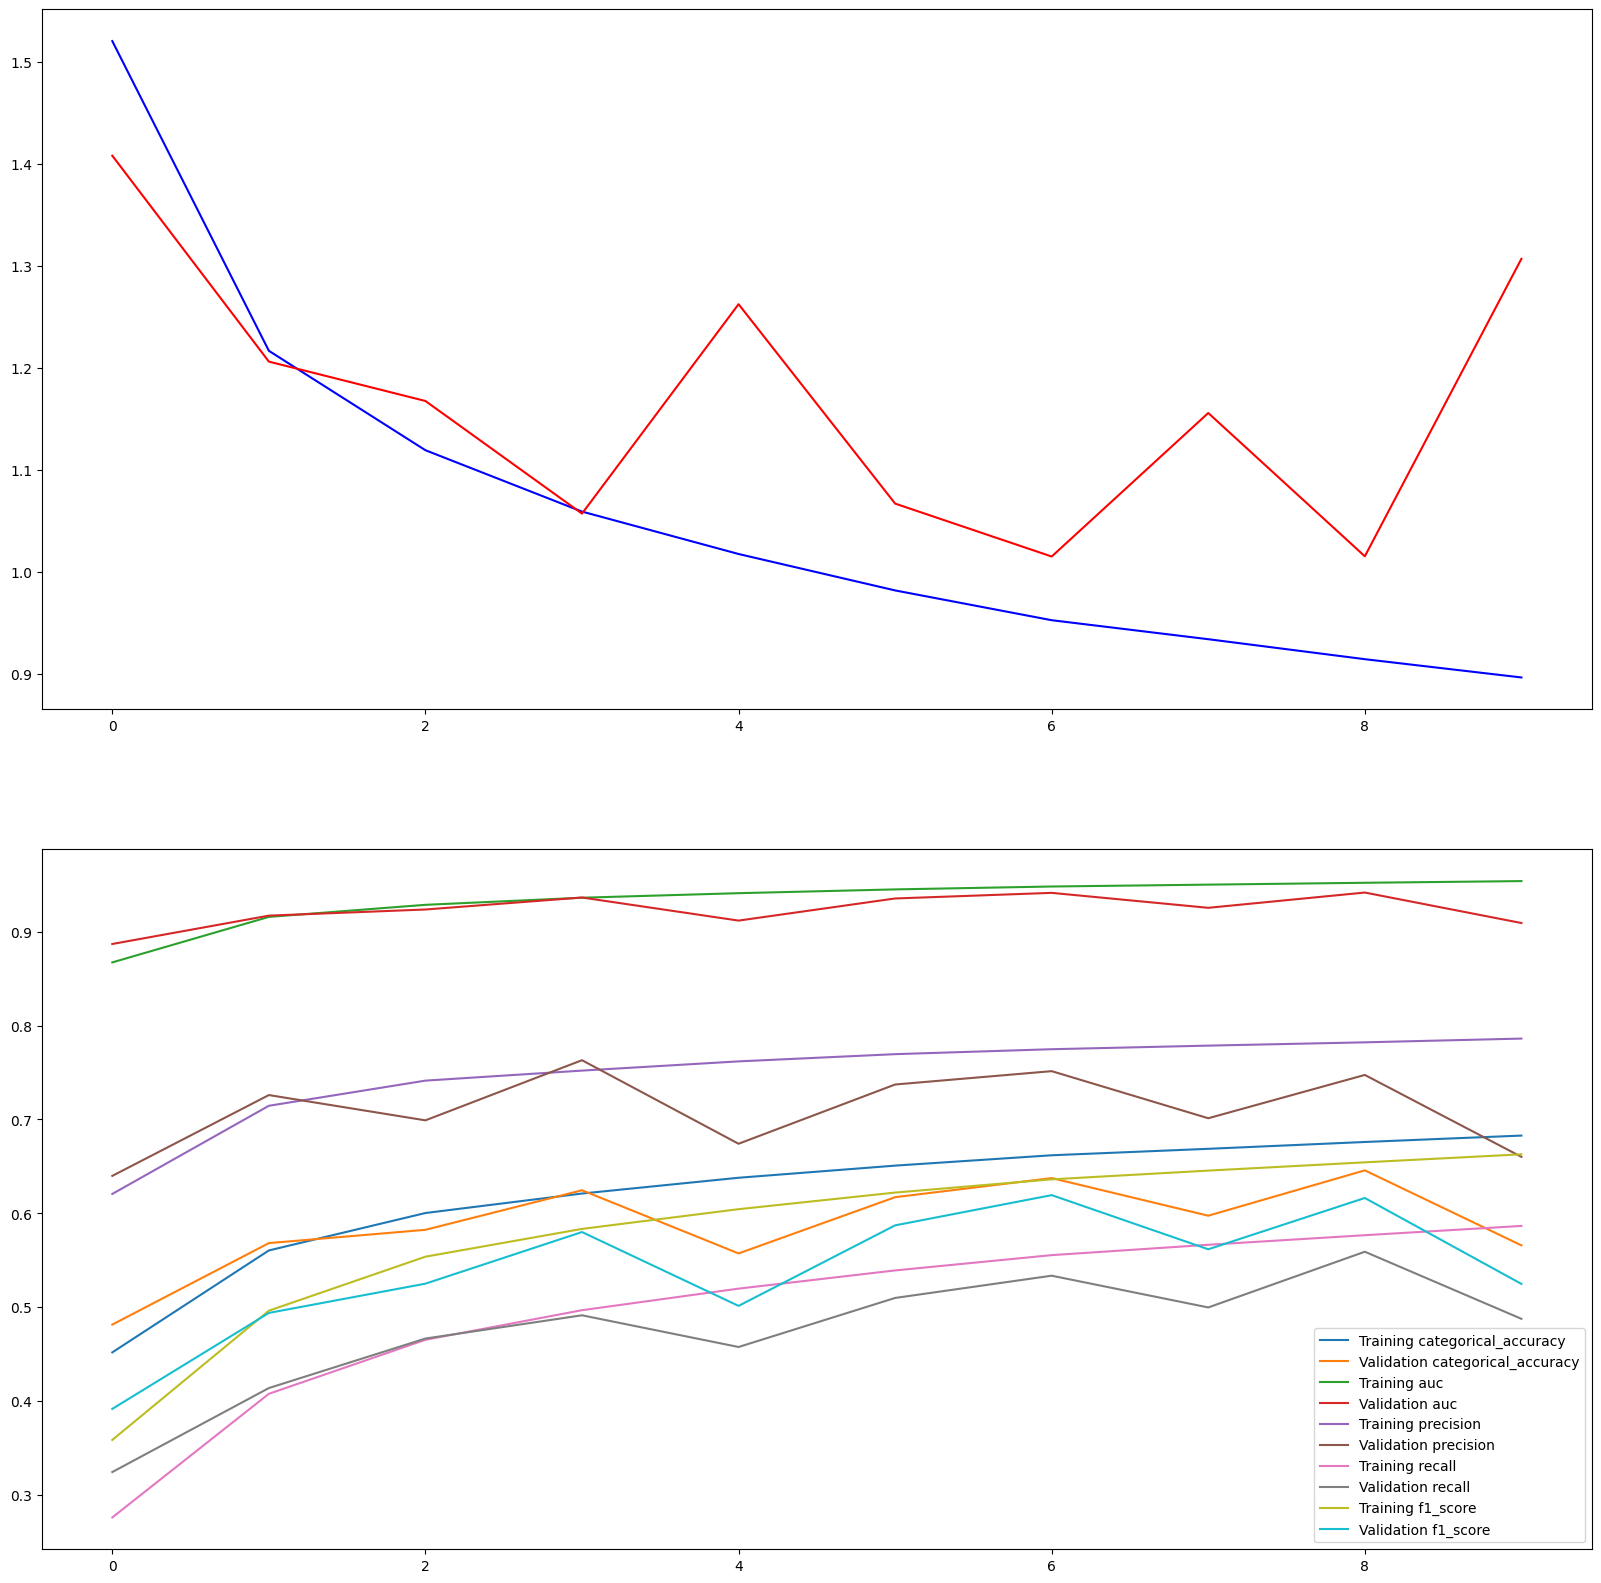

In [19]:
show_training_validation_loss_and_metrics(model1,metrics2)

In [20]:
model1.evaluate(test_it)

5625/5625 [==============================] - 102s 18ms/step - loss: 1.3147 - categorical_accuracy: 0.5618 - auc: 0.9080 - precision: 0.6567 - recall: 0.4847 - f1_score: 0.5224


[1.314723253250122,
 0.5617777705192566,
 0.9080199003219604,
 0.6567458510398865,
 0.48472222685813904,
 0.5224264860153198]

5625/5625 [==============================] - 13s 2ms/step


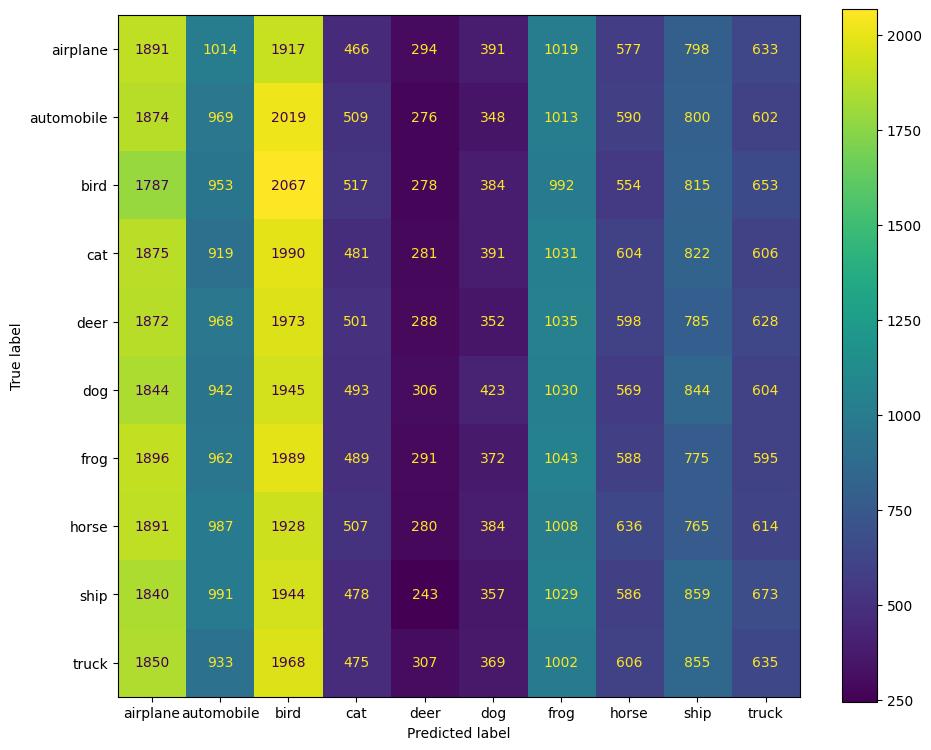

In [21]:
show_confusion_matrix(model1,test_ds,num_classes,class_names)

5625/5625 [==============================] - 15s 3ms/step


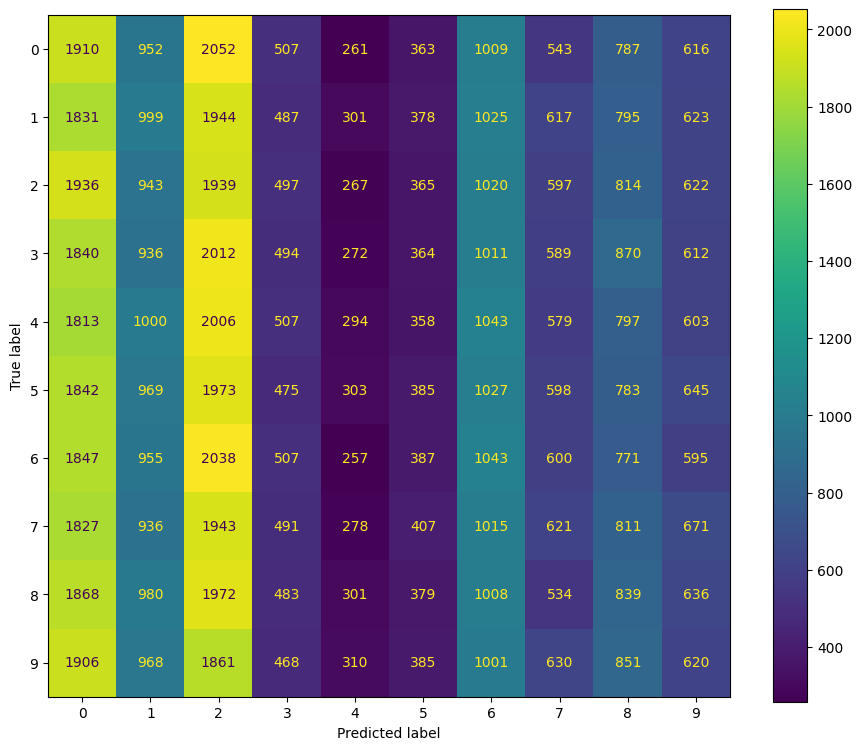

In [22]:
show_confusion_matrix_without_names(model1,test_ds,num_classes)

# Architektura drugiego modelu

In [23]:
model2 = create_model2(num_classes)

In [24]:
model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [25]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization (LayerN  (None, 32, 32, 75)       150       
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 75)       0         
 ooling2D)                                                       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_1 (Laye  (None, 16, 16, 50)       100       
 rNormalization)                                                 
                                                      

In [26]:
history = model2.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 159s 28ms/step - loss: 1.7273 - categorical_accuracy: 0.3739 - auc: 0.8208 - precision: 0.6081 - recall: 0.1495 - f1_score: 0.3967 - val_loss: 1.4765 - val_categorical_accuracy: 0.4600 - val_auc: 0.8739 - val_precision: 0.6728 - val_recall: 0.2290 - val_f1_score: 0.3038
Epoch 2/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.3969 - categorical_accuracy: 0.4951 - auc: 0.8876 - precision: 0.6852 - recall: 0.2950 - f1_score: 0.3832 - val_loss: 1.3651 - val_categorical_accuracy: 0.5022 - val_auc: 0.8931 - val_precision: 0.7027 - val_recall: 0.2980 - val_f1_score: 0.3903
Epoch 3/20
5625/5625 [==============================] - 127s 23ms/step - loss: 1.2902 - categorical_accuracy: 0.5331 - auc: 0.9048 - precision: 0.7063 - recall: 0.3555 - f1_score: 0.4456 - val_loss: 1.3017 - val_categorical_accuracy: 0.5262 - val_auc: 0.9032 - val_precision: 0.7060 - val_recall: 0.3458 - val_f1_score: 0.4238
Epoch 4/20
5625/562

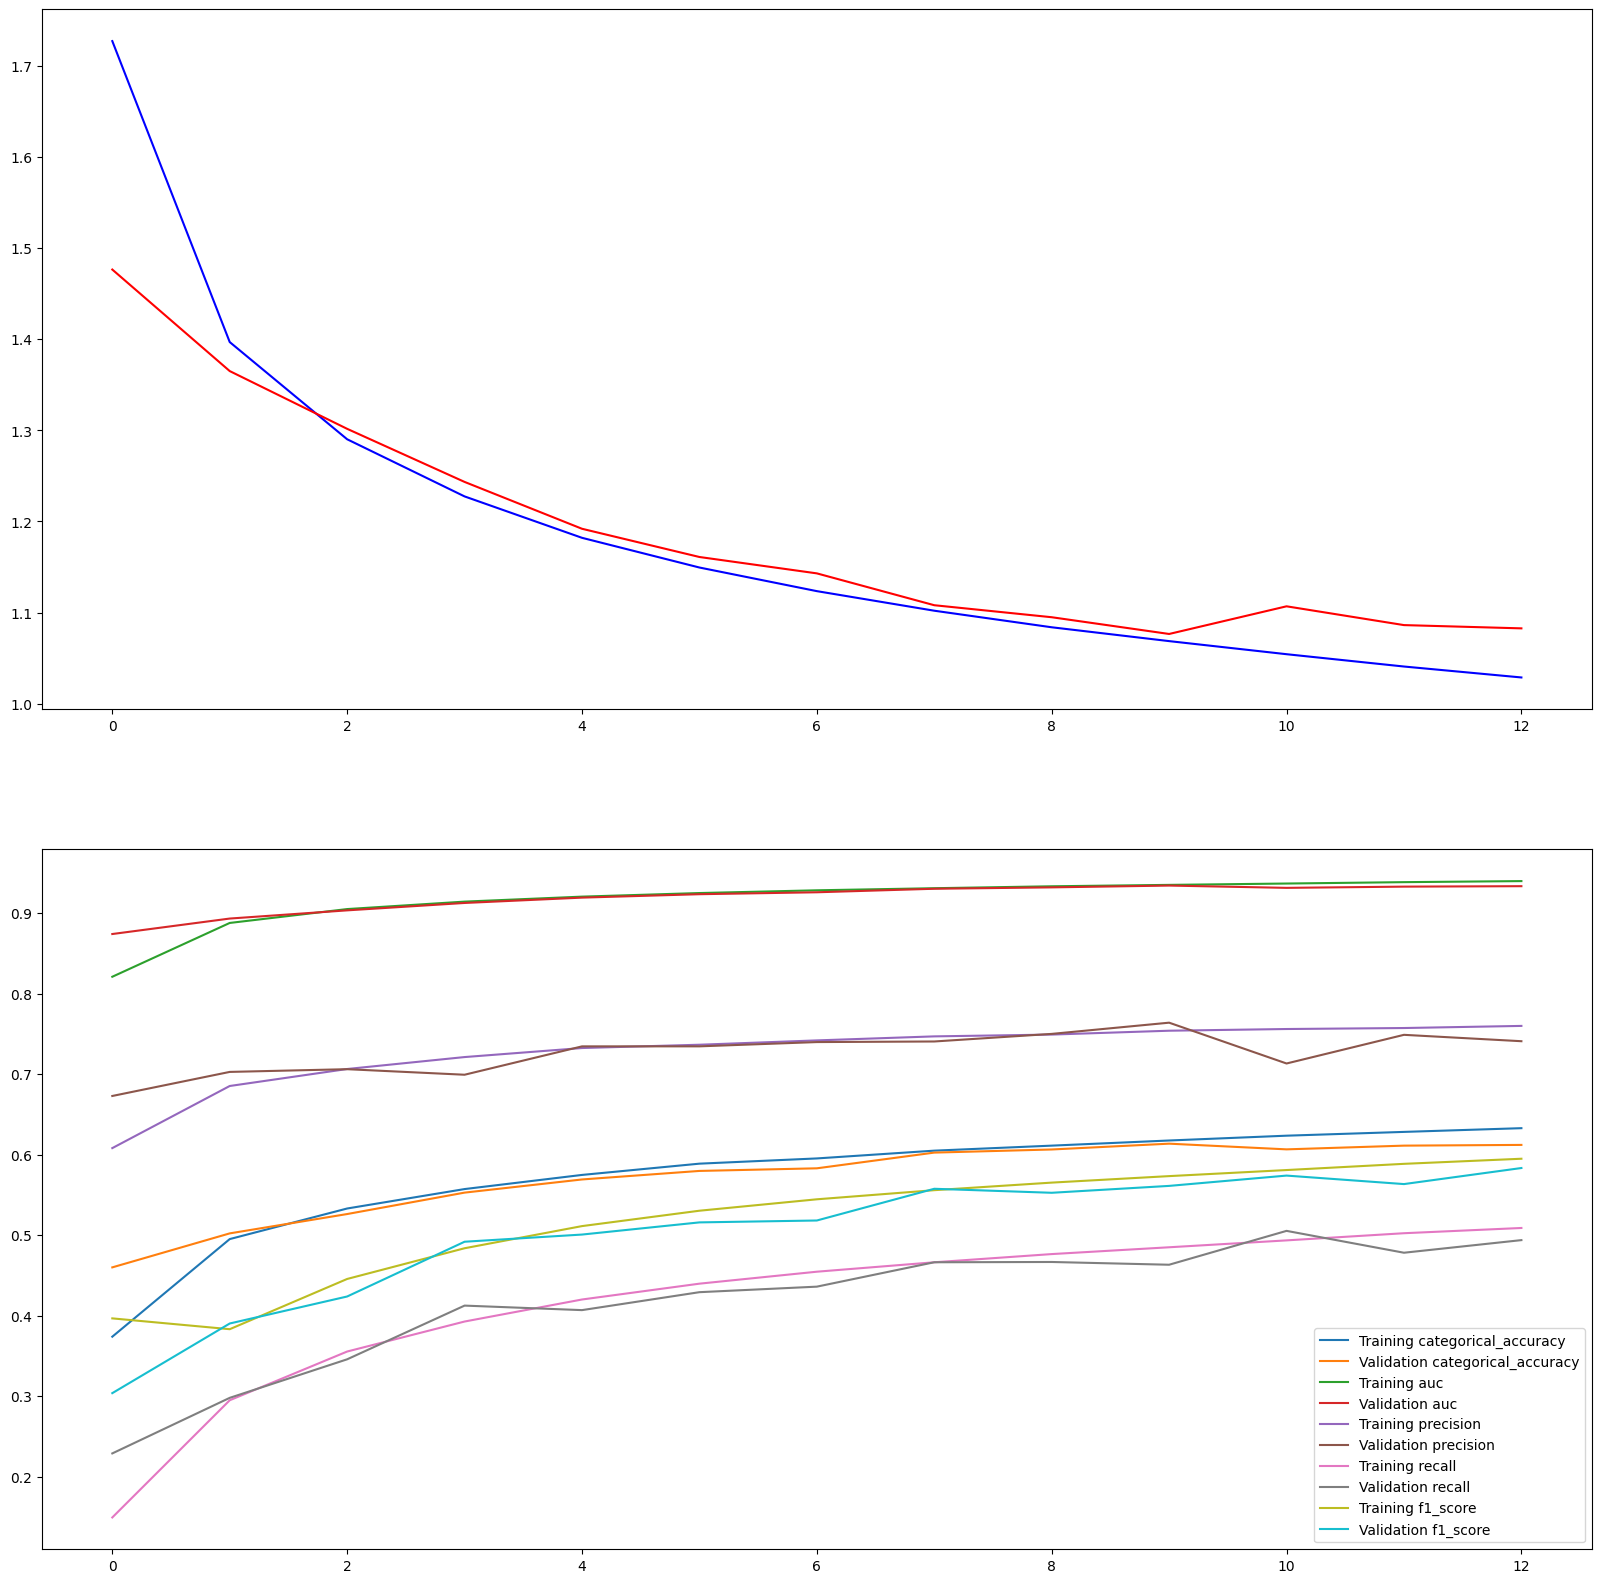

In [27]:
show_training_validation_loss_and_metrics(model2,metrics2)

In [28]:
model2.evaluate(test_it)

5625/5625 [==============================] - 81s 14ms/step - loss: 1.0910 - categorical_accuracy: 0.6123 - auc: 0.9321 - precision: 0.7403 - recall: 0.4935 - f1_score: 0.5833


[1.09103524684906,
 0.6122888922691345,
 0.9321048855781555,
 0.7403160333633423,
 0.4935111105442047,
 0.5833054780960083]

5625/5625 [==============================] - 14s 2ms/step


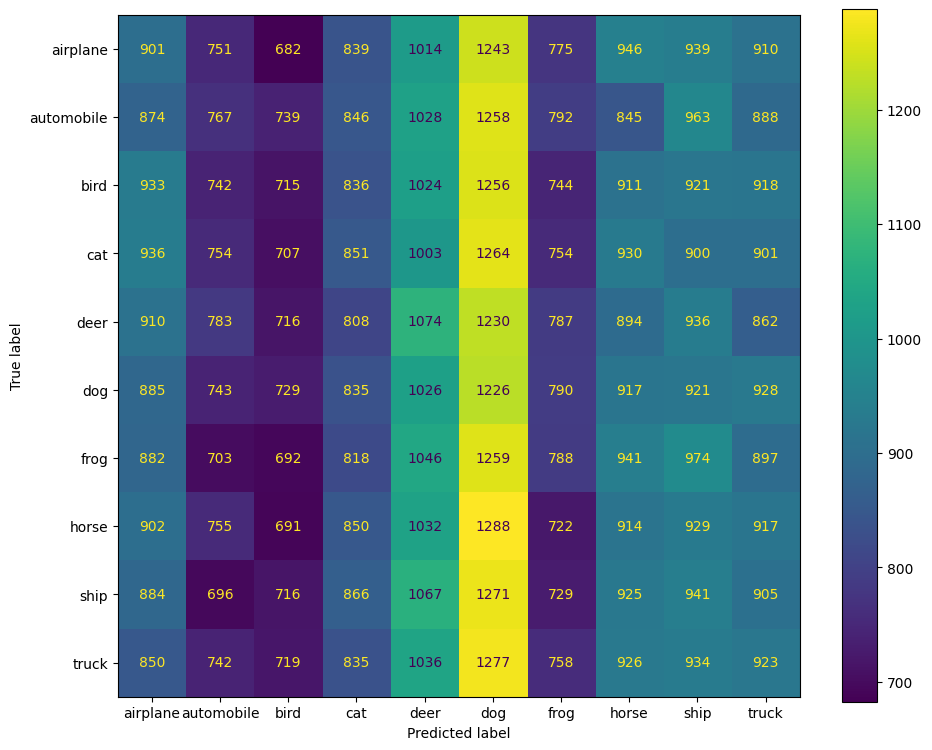

In [29]:
show_confusion_matrix(model2,test_ds,num_classes,class_names)

5625/5625 [==============================] - 14s 3ms/step


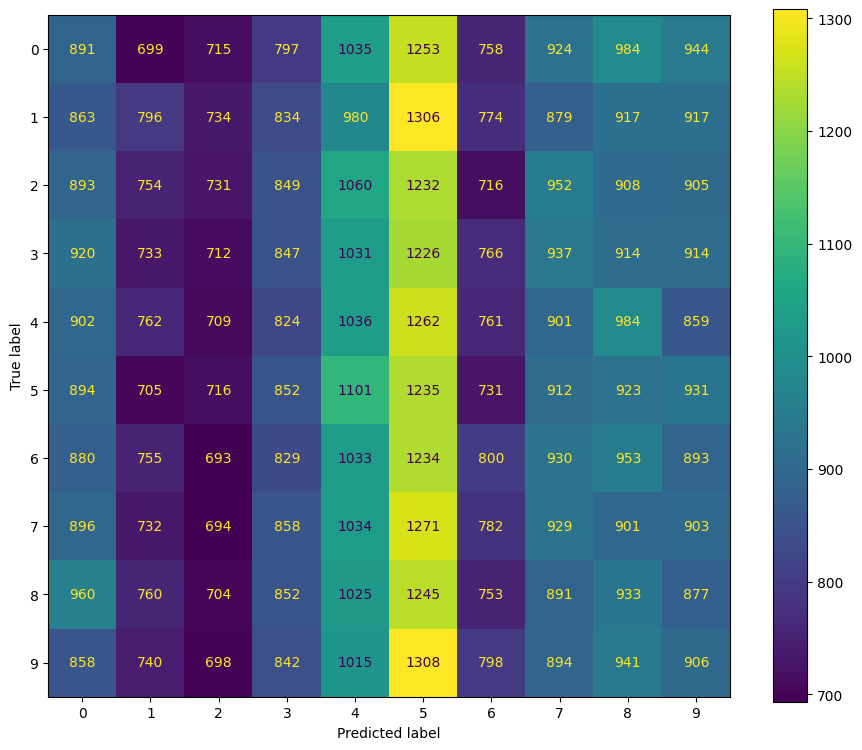

In [30]:
show_confusion_matrix_without_names(model2,test_ds,num_classes)

# Architektura trzeciego modelu

In [31]:
model3 = create_model3(num_classes)

In [32]:
model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [33]:
history = model3.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.6718 - categorical_accuracy: 0.3684 - auc: 0.8313 - precision: 0.6286 - recall: 0.1386 - f1_score: 0.4251 - val_loss: 1.4425 - val_categorical_accuracy: 0.4614 - val_auc: 0.8808 - val_precision: 0.6466 - val_recall: 0.2627 - val_f1_score: 0.3263
Epoch 2/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.3733 - categorical_accuracy: 0.4921 - auc: 0.8918 - precision: 0.6850 - recall: 0.2952 - f1_score: 0.3750 - val_loss: 1.2920 - val_categorical_accuracy: 0.5271 - val_auc: 0.9050 - val_precision: 0.7206 - val_recall: 0.3263 - val_f1_score: 0.4000
Epoch 3/20
5625/5625 [==============================] - 128s 23ms/step - loss: 1.2636 - categorical_accuracy: 0.5377 - auc: 0.9090 - precision: 0.7098 - recall: 0.3624 - f1_score: 0.4477 - val_loss: 1.2404 - val_categorical_accuracy: 0.5472 - val_auc: 0.9124 - val_precision: 0.7127 - val_recall: 0.3859 - val_f1_score: 0.4667
Epoch 4/20
5625/562

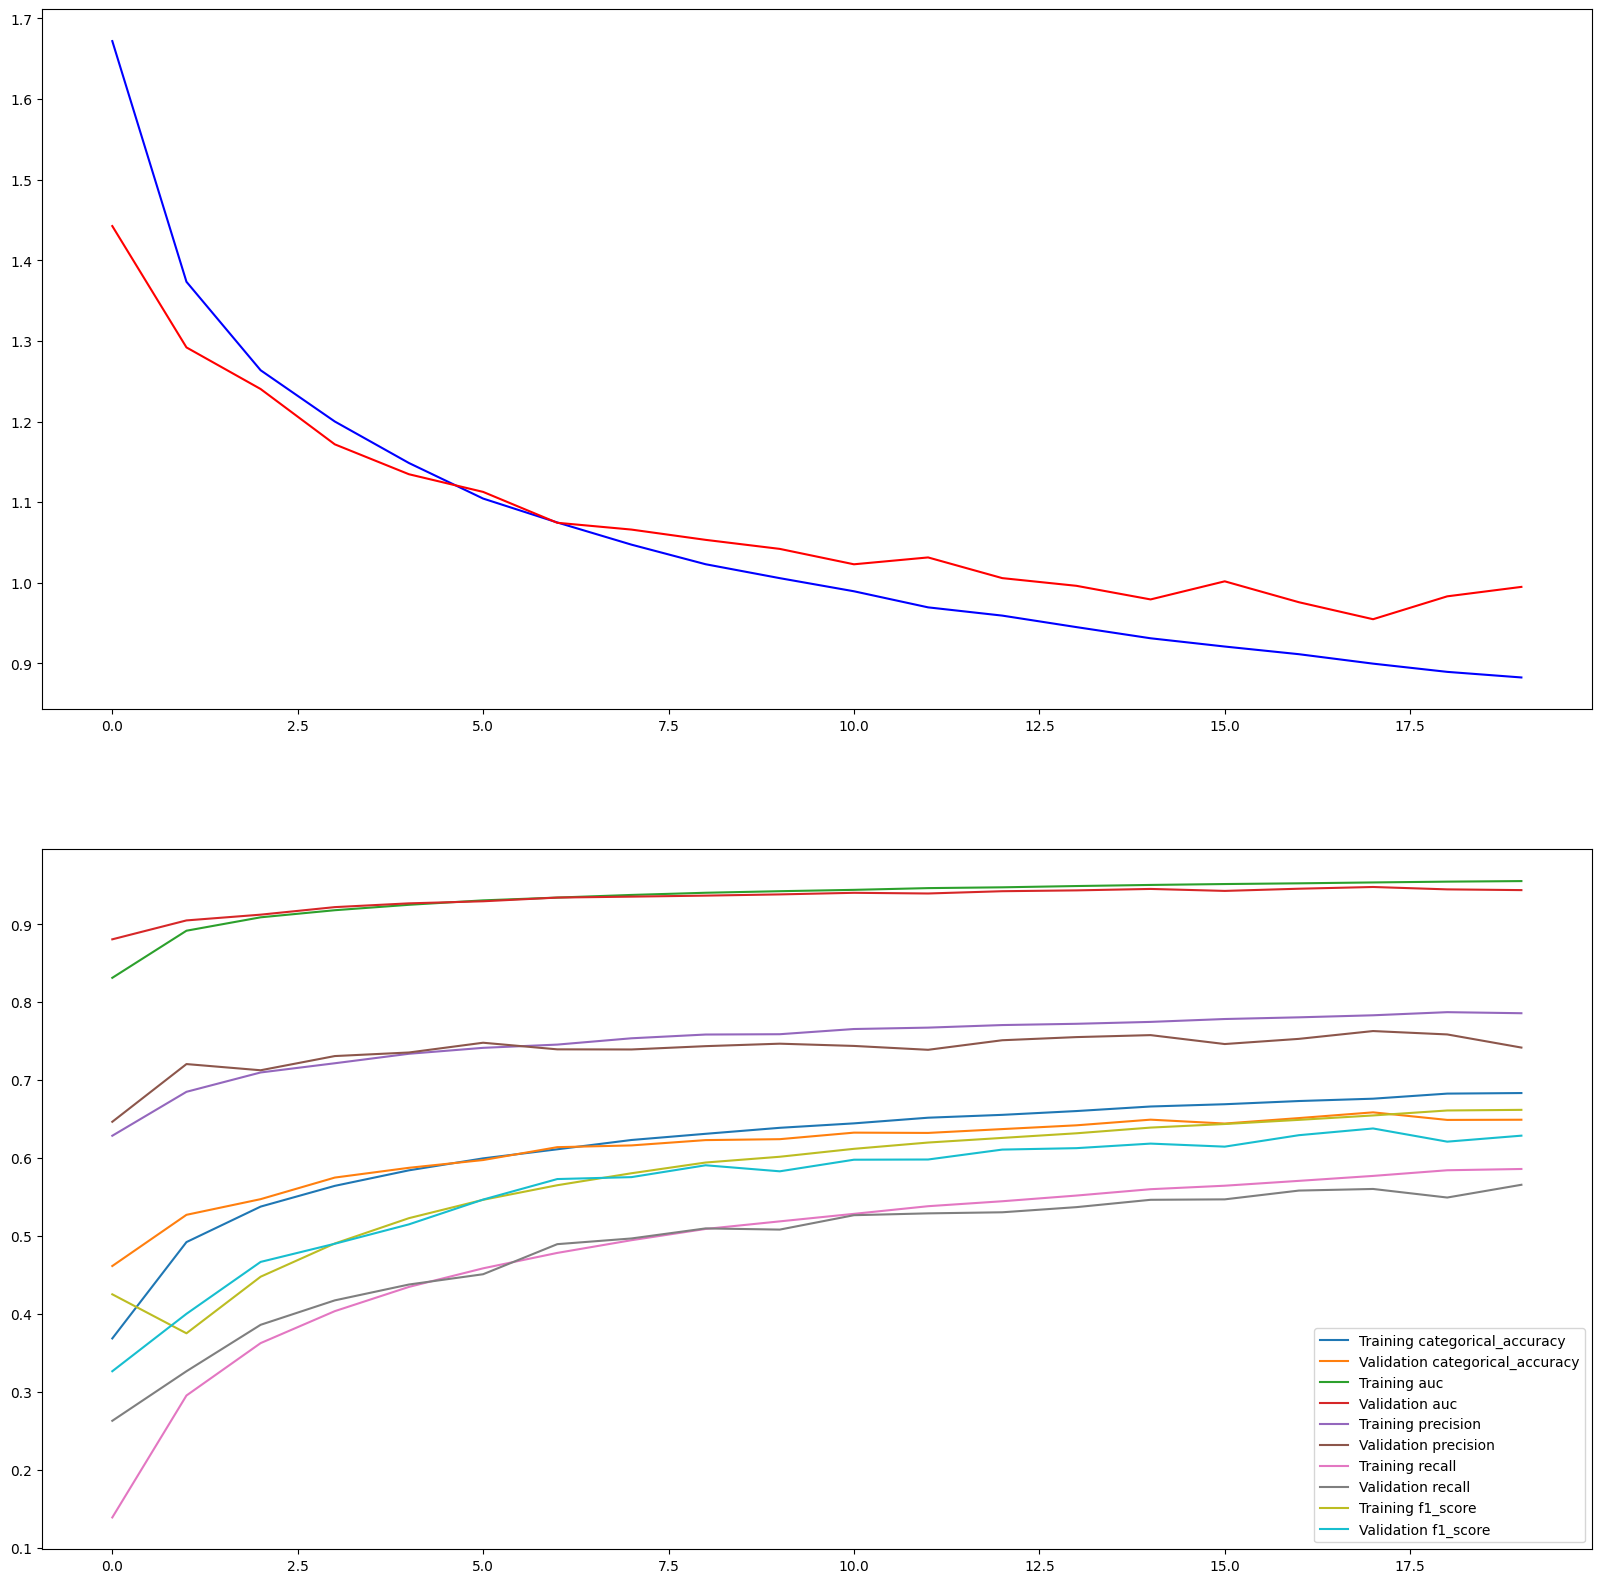

In [34]:
show_training_validation_loss_and_metrics(model3,metrics2)

In [35]:
model3.evaluate(test_it)

5625/5625 [==============================] - 82s 15ms/step - loss: 1.0074 - categorical_accuracy: 0.6474 - auc: 0.9427 - precision: 0.7417 - recall: 0.5654 - f1_score: 0.6284


[1.0074260234832764,
 0.6473777890205383,
 0.9426985383033752,
 0.7417356371879578,
 0.5654333233833313,
 0.6284117698669434]

5625/5625 [==============================] - 18s 3ms/step


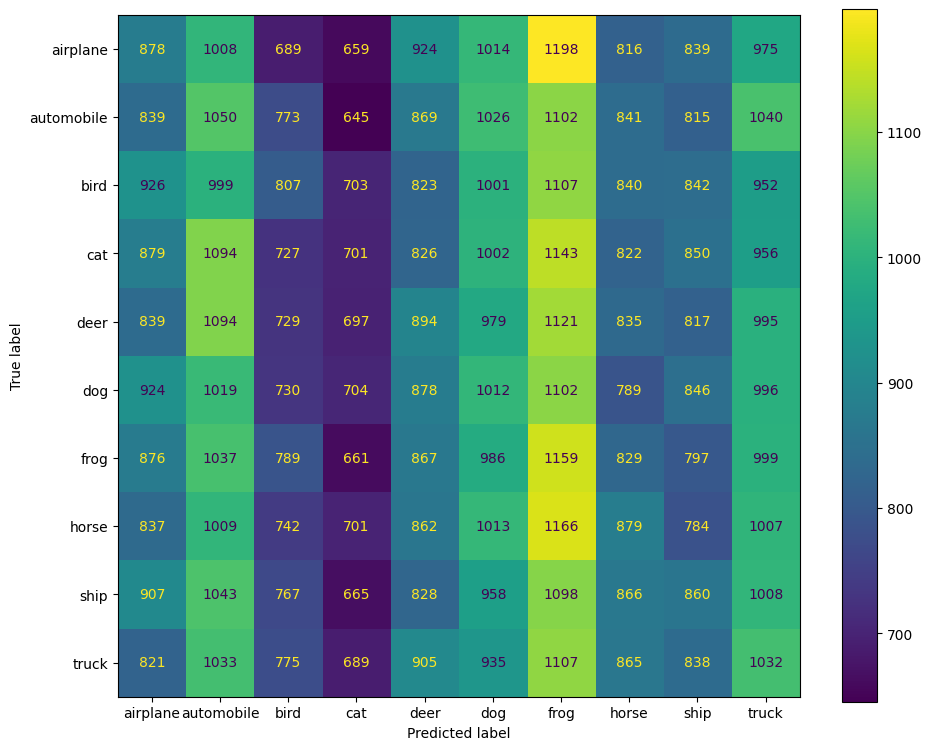

In [36]:
show_confusion_matrix(model3,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


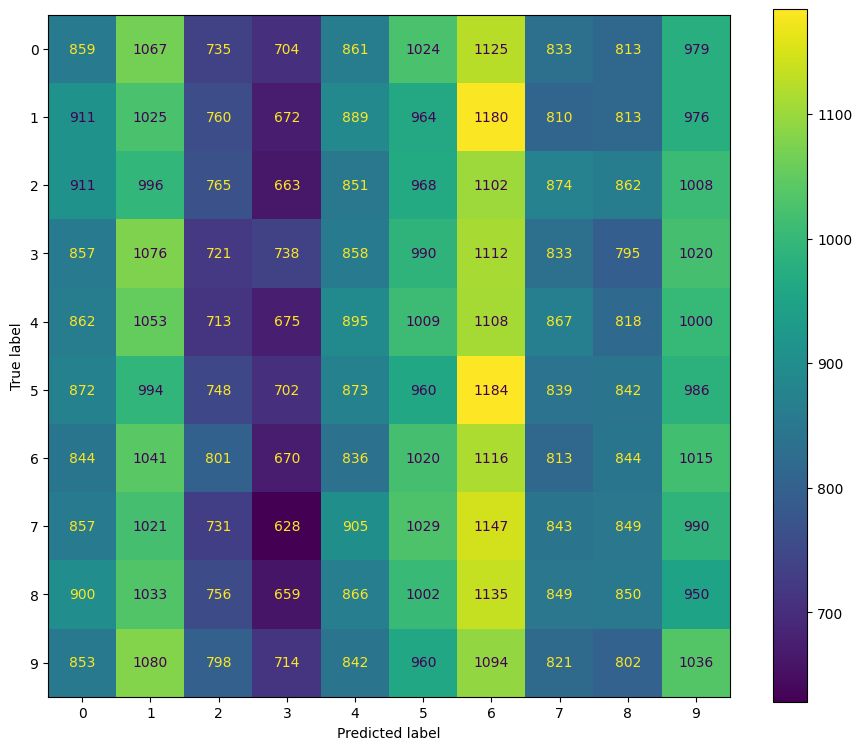

In [37]:
show_confusion_matrix_without_names(model3,test_ds,num_classes)

# Ziarno 1234

In [38]:
SEED = 1234
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [39]:
model11 = create_model1(num_classes)

In [40]:
model11.compile( 
    loss=loss_func,
    metrics=metrics
)

In [41]:
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [42]:
history = model11.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.5306 - categorical_accuracy: 0.4474 - auc: 0.8653 - precision: 0.6198 - recall: 0.2696 - f1_score: 0.5055 - val_loss: 1.5273 - val_categorical_accuracy: 0.4673 - val_auc: 0.8699 - val_precision: 0.6146 - val_recall: 0.3487 - val_f1_score: 0.3888
Epoch 2/20
5625/5625 [==============================] - 120s 21ms/step - loss: 1.2238 - categorical_accuracy: 0.5585 - auc: 0.9147 - precision: 0.7138 - recall: 0.4035 - f1_score: 0.4922 - val_loss: 1.5224 - val_categorical_accuracy: 0.4811 - val_auc: 0.8769 - val_precision: 0.5864 - val_recall: 0.3760 - val_f1_score: 0.4140
Epoch 3/20
5625/5625 [==============================] - 121s 22ms/step - loss: 1.1259 - categorical_accuracy: 0.5981 - auc: 0.9278 - precision: 0.7388 - recall: 0.4609 - f1_score: 0.5491 - val_loss: 1.6417 - val_categorical_accuracy: 0.4643 - val_auc: 0.8654 - val_precision: 0.5568 - val_recall: 0.3737 - val_f1_score: 0.3994
Epoch 4/20
5625/562

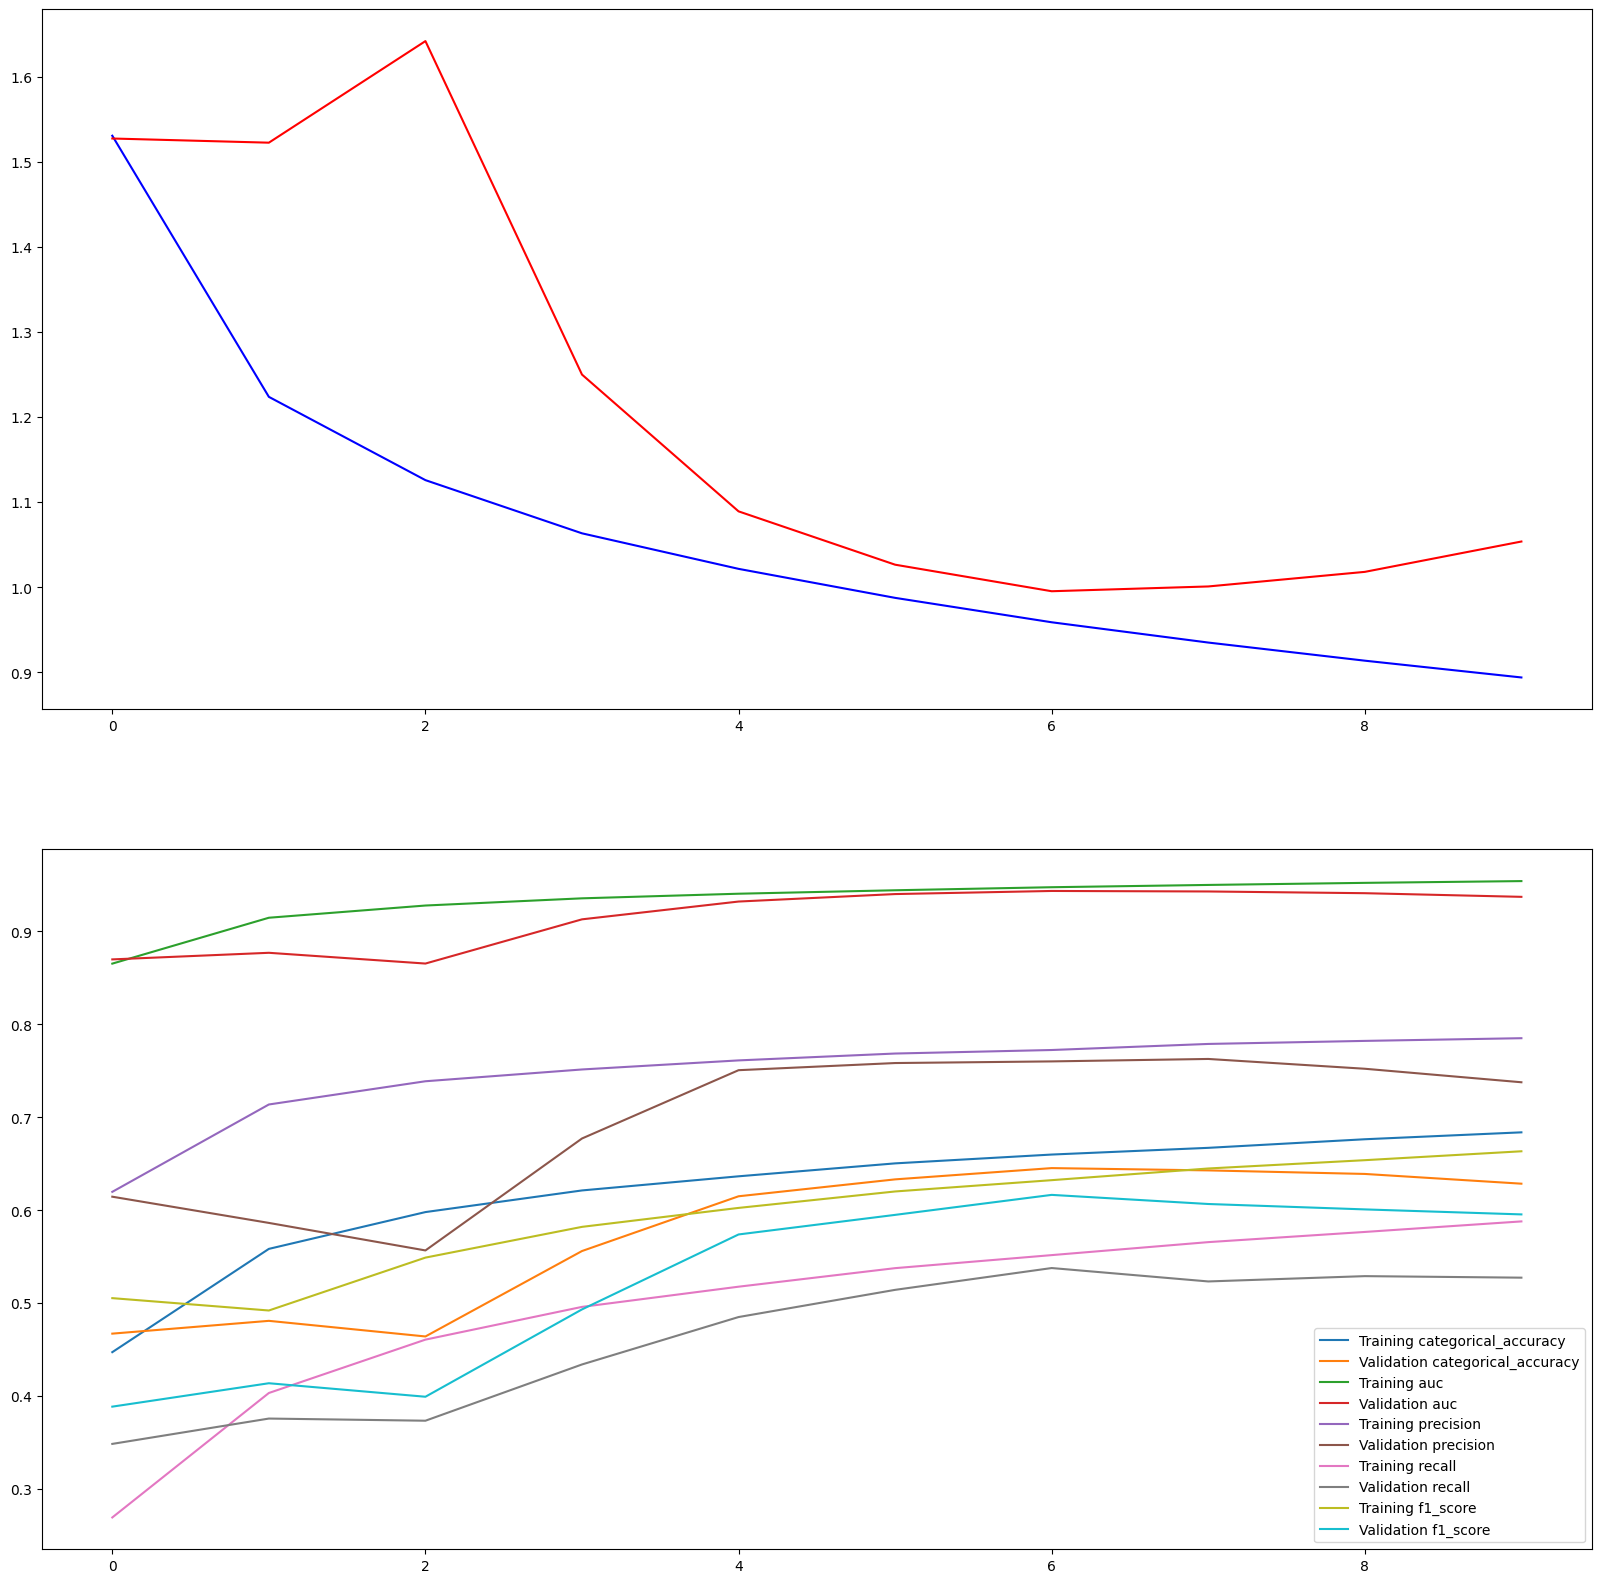

In [43]:
show_training_validation_loss_and_metrics(model11,metrics2)

In [44]:
model11.evaluate(test_it)

5625/5625 [==============================] - 62s 11ms/step - loss: 1.0640 - categorical_accuracy: 0.6253 - auc: 0.9362 - precision: 0.7336 - recall: 0.5266 - f1_score: 0.5943


[1.0640145540237427,
 0.6253111362457275,
 0.9361544251441956,
 0.7335851192474365,
 0.5266000032424927,
 0.5942527055740356]

5625/5625 [==============================] - 15s 3ms/step


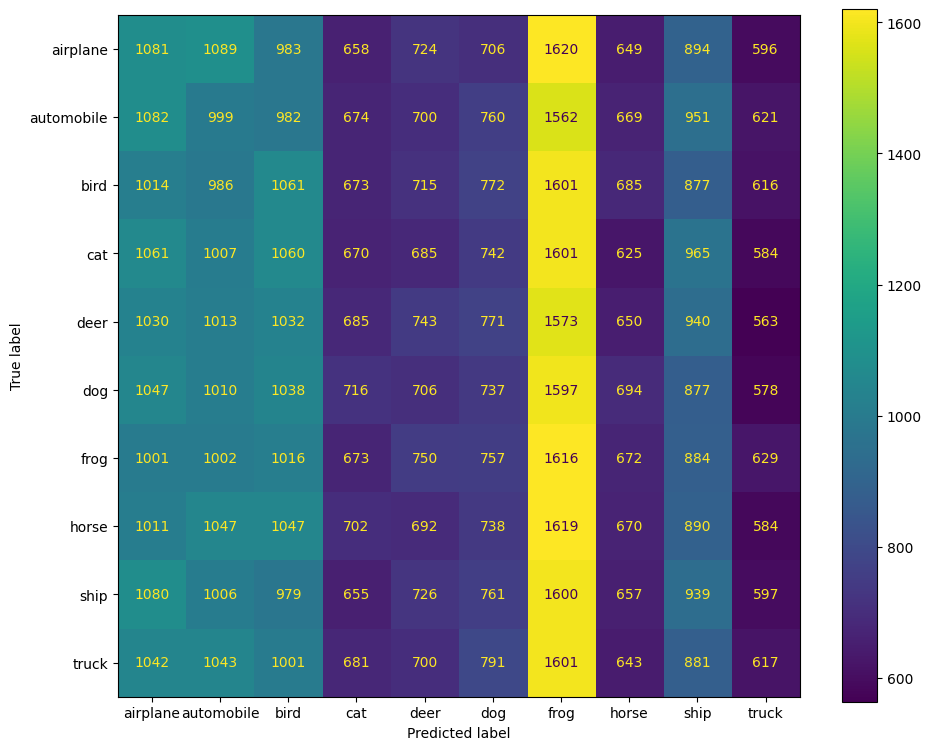

In [45]:
show_confusion_matrix(model11,test_ds,num_classes,class_names)

5625/5625 [==============================] - 15s 3ms/step


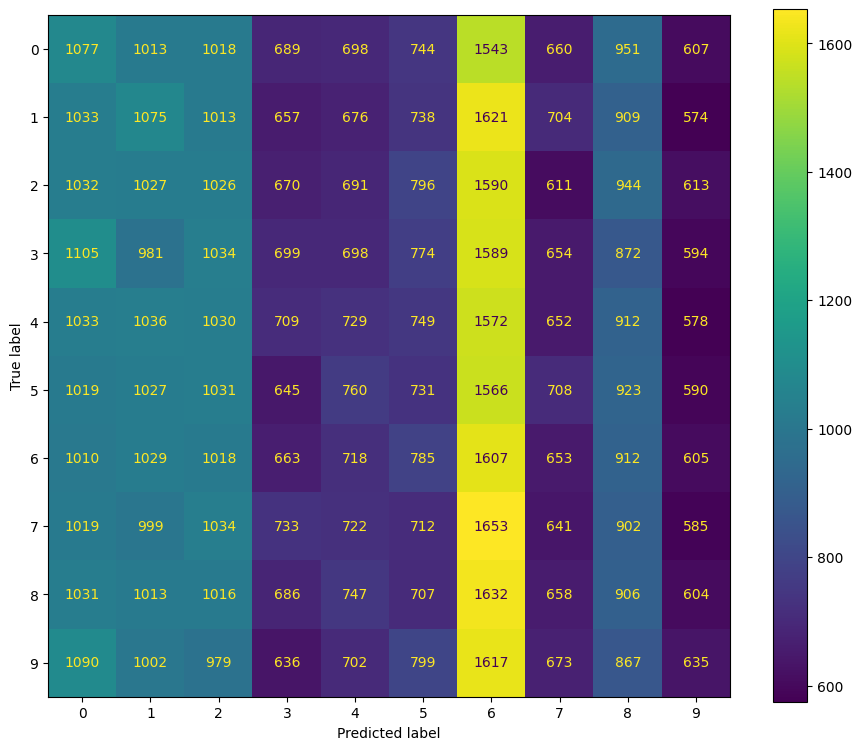

In [46]:
show_confusion_matrix_without_names(model11,test_ds,num_classes)

# Architektura drugiego modelu

In [47]:
model21 = create_model2(num_classes)

In [48]:
model21.compile( 
    loss=loss_func,
    metrics=metrics
)

In [49]:
model21.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_9 (Laye  (None, 32, 32, 75)       150       
 rNormalization)                                                 
                                                                 
 average_pooling2d_3 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_17 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_10 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [50]:
history = model21.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 124s 22ms/step - loss: 1.6873 - categorical_accuracy: 0.3844 - auc: 0.8296 - precision: 0.6187 - recall: 0.1643 - f1_score: 0.4438 - val_loss: 1.5447 - val_categorical_accuracy: 0.4415 - val_auc: 0.8606 - val_precision: 0.7120 - val_recall: 0.2035 - val_f1_score: 0.2962
Epoch 2/20
5625/5625 [==============================] - 129s 23ms/step - loss: 1.3599 - categorical_accuracy: 0.5049 - auc: 0.8937 - precision: 0.6941 - recall: 0.3147 - f1_score: 0.4018 - val_loss: 1.3636 - val_categorical_accuracy: 0.5065 - val_auc: 0.8930 - val_precision: 0.7015 - val_recall: 0.3112 - val_f1_score: 0.3946
Epoch 3/20
5625/5625 [==============================] - 126s 22ms/step - loss: 1.2648 - categorical_accuracy: 0.5424 - auc: 0.9085 - precision: 0.7183 - recall: 0.3715 - f1_score: 0.4611 - val_loss: 1.2802 - val_categorical_accuracy: 0.5387 - val_auc: 0.9061 - val_precision: 0.7185 - val_recall: 0.3607 - val_f1_score: 0.4361
Epoch 4/20
5625/562

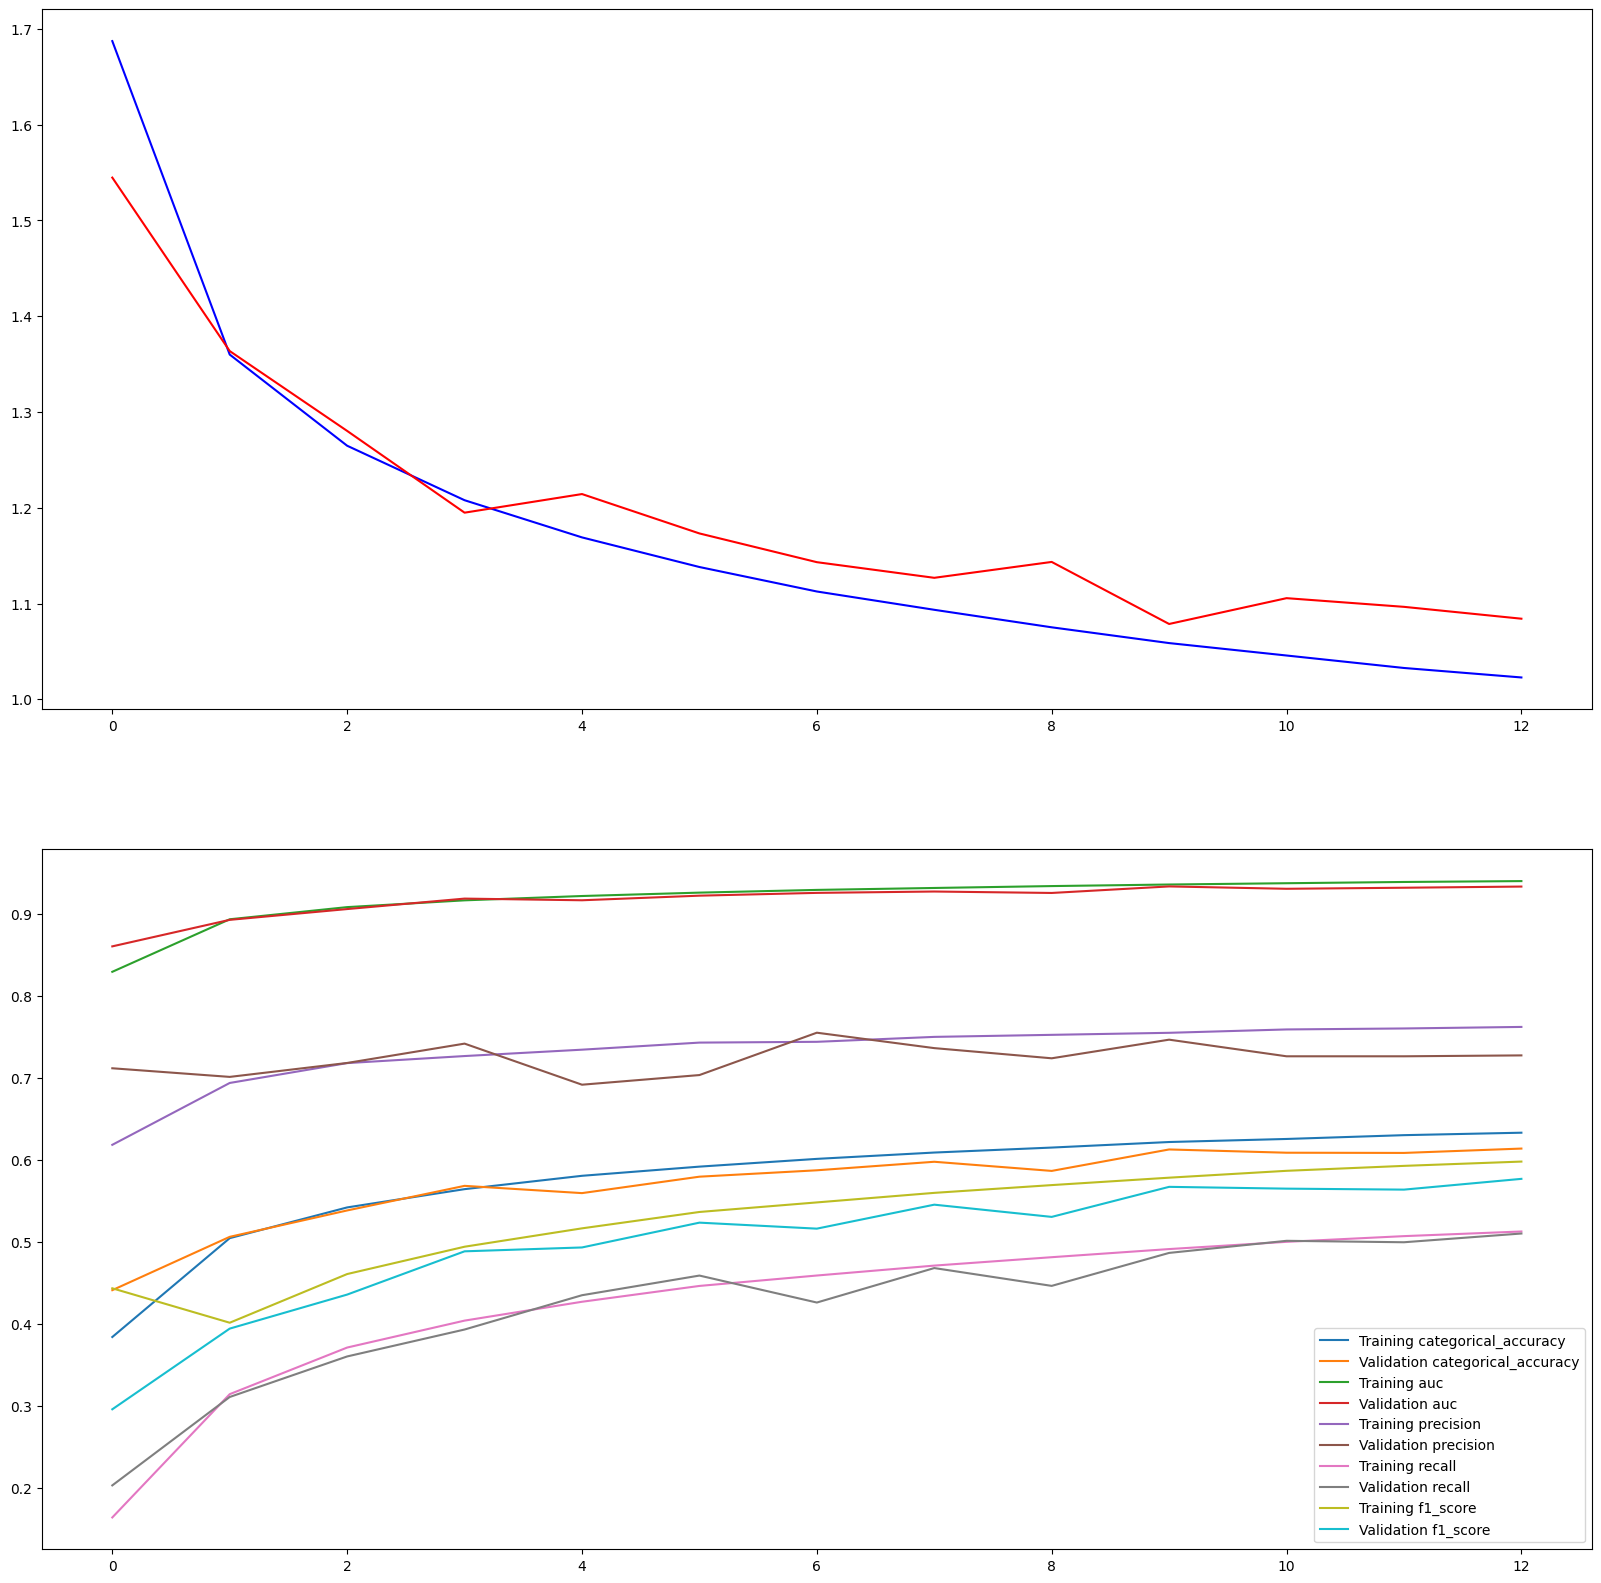

In [51]:
show_training_validation_loss_and_metrics(model21,metrics2)

In [52]:
model21.evaluate(test_it)

5625/5625 [==============================] - 85s 15ms/step - loss: 1.0879 - categorical_accuracy: 0.6137 - auc: 0.9330 - precision: 0.7271 - recall: 0.5090 - f1_score: 0.5761


[1.0879400968551636,
 0.6136555671691895,
 0.9329623579978943,
 0.7271024584770203,
 0.5090444684028625,
 0.5760970115661621]

5625/5625 [==============================] - 17s 3ms/step


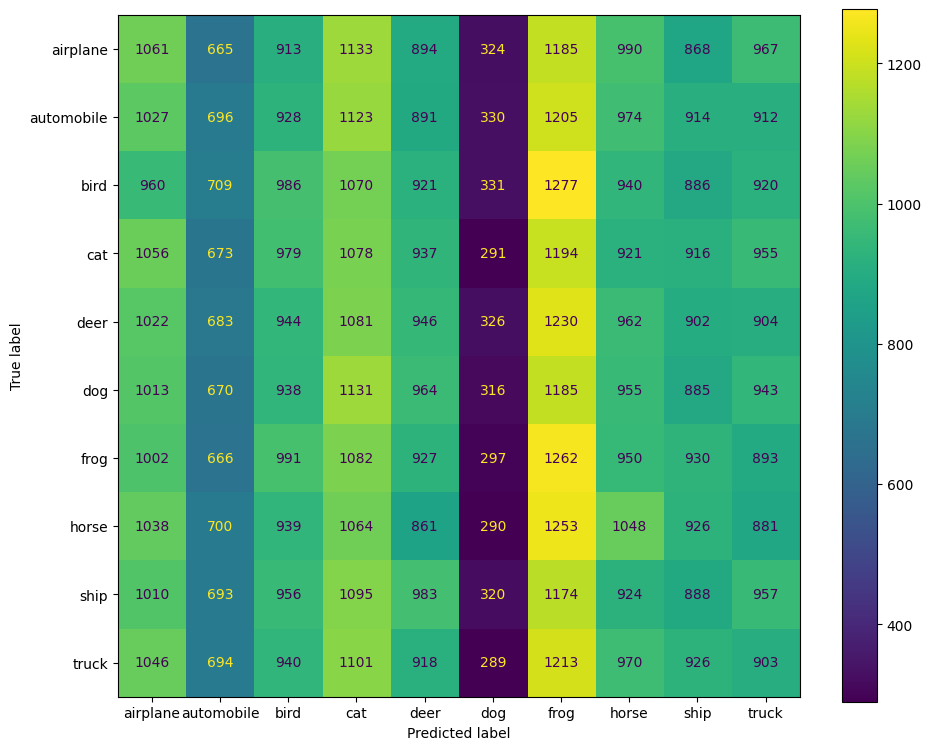

In [53]:
show_confusion_matrix(model21,test_ds,num_classes,class_names)

5625/5625 [==============================] - 14s 3ms/step


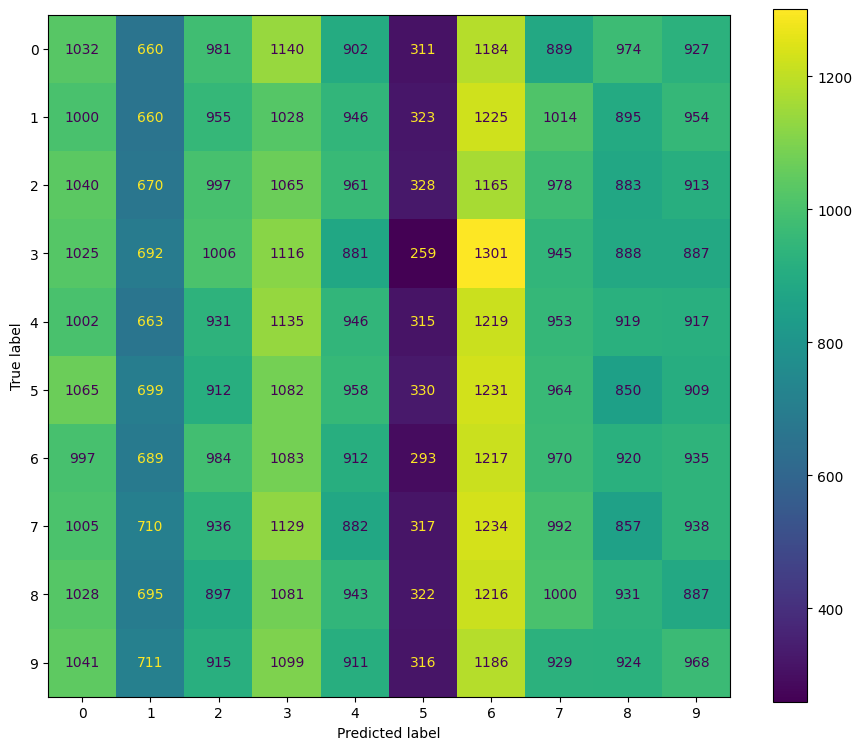

In [54]:
show_confusion_matrix_without_names(model21,test_ds,num_classes)

# Architektura trzeciego modelu

In [55]:
model31 = create_model3(num_classes)

model31.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [56]:
history = model31.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 124s 22ms/step - loss: 1.6619 - categorical_accuracy: 0.3736 - auc: 0.8340 - precision: 0.6287 - recall: 0.1401 - f1_score: 0.4236 - val_loss: 1.4132 - val_categorical_accuracy: 0.4744 - val_auc: 0.8854 - val_precision: 0.6892 - val_recall: 0.2496 - val_f1_score: 0.3185
Epoch 2/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.3723 - categorical_accuracy: 0.4942 - auc: 0.8919 - precision: 0.6882 - recall: 0.2947 - f1_score: 0.3733 - val_loss: 1.2928 - val_categorical_accuracy: 0.5250 - val_auc: 0.9047 - val_precision: 0.6948 - val_recall: 0.3530 - val_f1_score: 0.4246
Epoch 3/20
5625/5625 [==============================] - 124s 22ms/step - loss: 1.2651 - categorical_accuracy: 0.5374 - auc: 0.9088 - precision: 0.7114 - recall: 0.3602 - f1_score: 0.4436 - val_loss: 1.2366 - val_categorical_accuracy: 0.5495 - val_auc: 0.9131 - val_precision: 0.6998 - val_recall: 0.3960 - val_f1_score: 0.4623
Epoch 4/20
5625/5625 [========

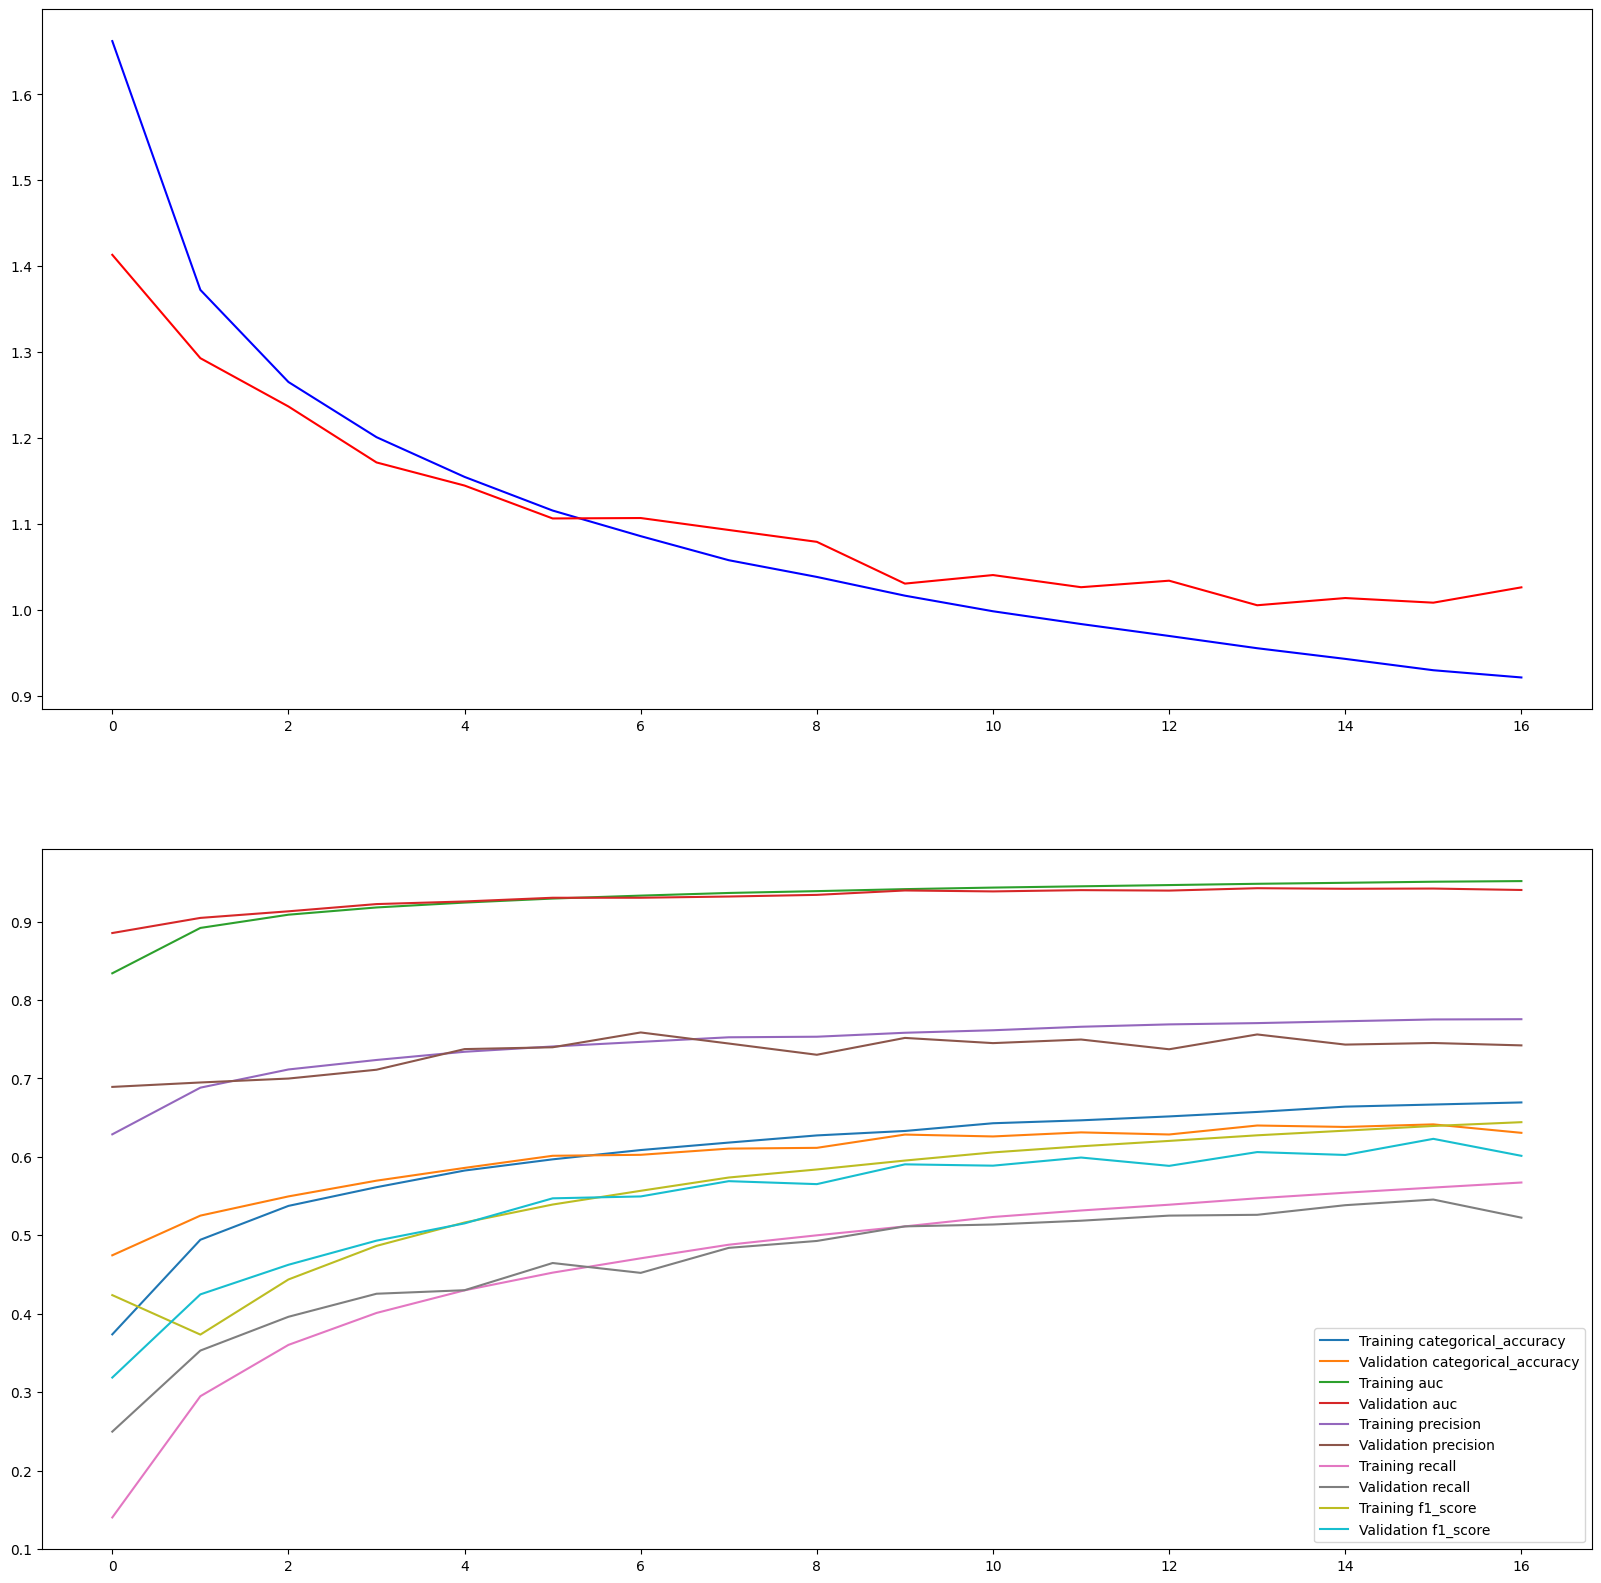

In [57]:
show_training_validation_loss_and_metrics(model31,metrics2)

In [58]:
model31.evaluate(test_it)

5625/5625 [==============================] - 65s 12ms/step - loss: 1.0364 - categorical_accuracy: 0.6272 - auc: 0.9389 - precision: 0.7396 - recall: 0.5196 - f1_score: 0.5982


[1.0363645553588867,
 0.6272444725036621,
 0.938907265663147,
 0.7395698428153992,
 0.5195888876914978,
 0.5982367992401123]

5625/5625 [==============================] - 18s 3ms/step


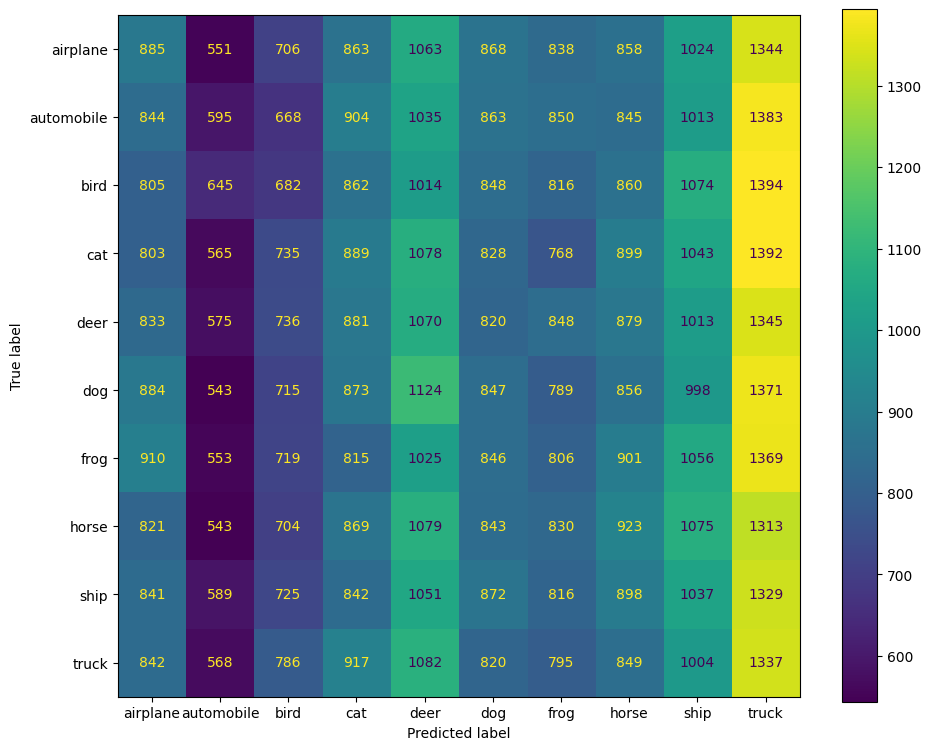

In [59]:
show_confusion_matrix(model31,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


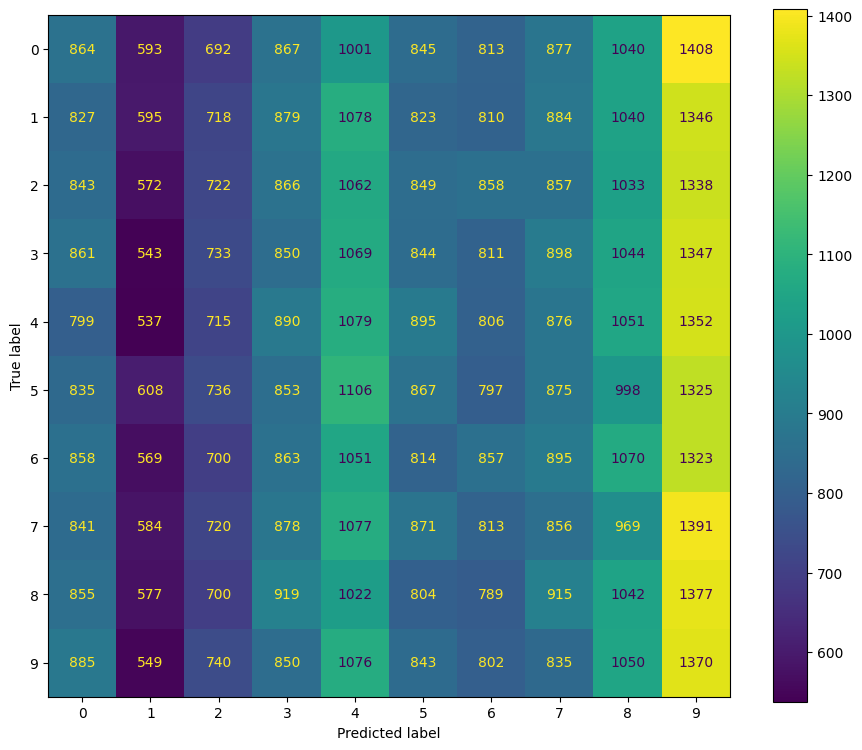

In [60]:
show_confusion_matrix_without_names(model31,test_ds,num_classes)

# Ziarno 2137

In [61]:
SEED = 2137

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [62]:
model12 = create_model1(num_classes)

In [63]:
model12.compile( 
    loss=loss_func,
    metrics=metrics
)

In [64]:
model12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                      

In [65]:
history = model12.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 123s 22ms/step - loss: 1.5370 - categorical_accuracy: 0.4470 - auc: 0.8641 - precision: 0.6189 - recall: 0.2690 - f1_score: 0.4874 - val_loss: 1.5861 - val_categorical_accuracy: 0.4465 - val_auc: 0.8612 - val_precision: 0.5654 - val_recall: 0.3083 - val_f1_score: 0.3522
Epoch 2/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.2196 - categorical_accuracy: 0.5631 - auc: 0.9151 - precision: 0.7167 - recall: 0.4104 - f1_score: 0.5002 - val_loss: 1.2053 - val_categorical_accuracy: 0.5733 - val_auc: 0.9170 - val_precision: 0.7225 - val_recall: 0.4299 - val_f1_score: 0.5089
Epoch 3/20
5625/5625 [==============================] - 124s 22ms/step - loss: 1.1209 - categorical_accuracy: 0.5994 - auc: 0.9284 - precision: 0.7379 - recall: 0.4636 - f1_score: 0.5516 - val_loss: 1.1564 - val_categorical_accuracy: 0.5868 - val_auc: 0.9237 - val_precision: 0.7599 - val_recall: 0.4294 - val_f1_score: 0.5161
Epoch 4/20
5625/562

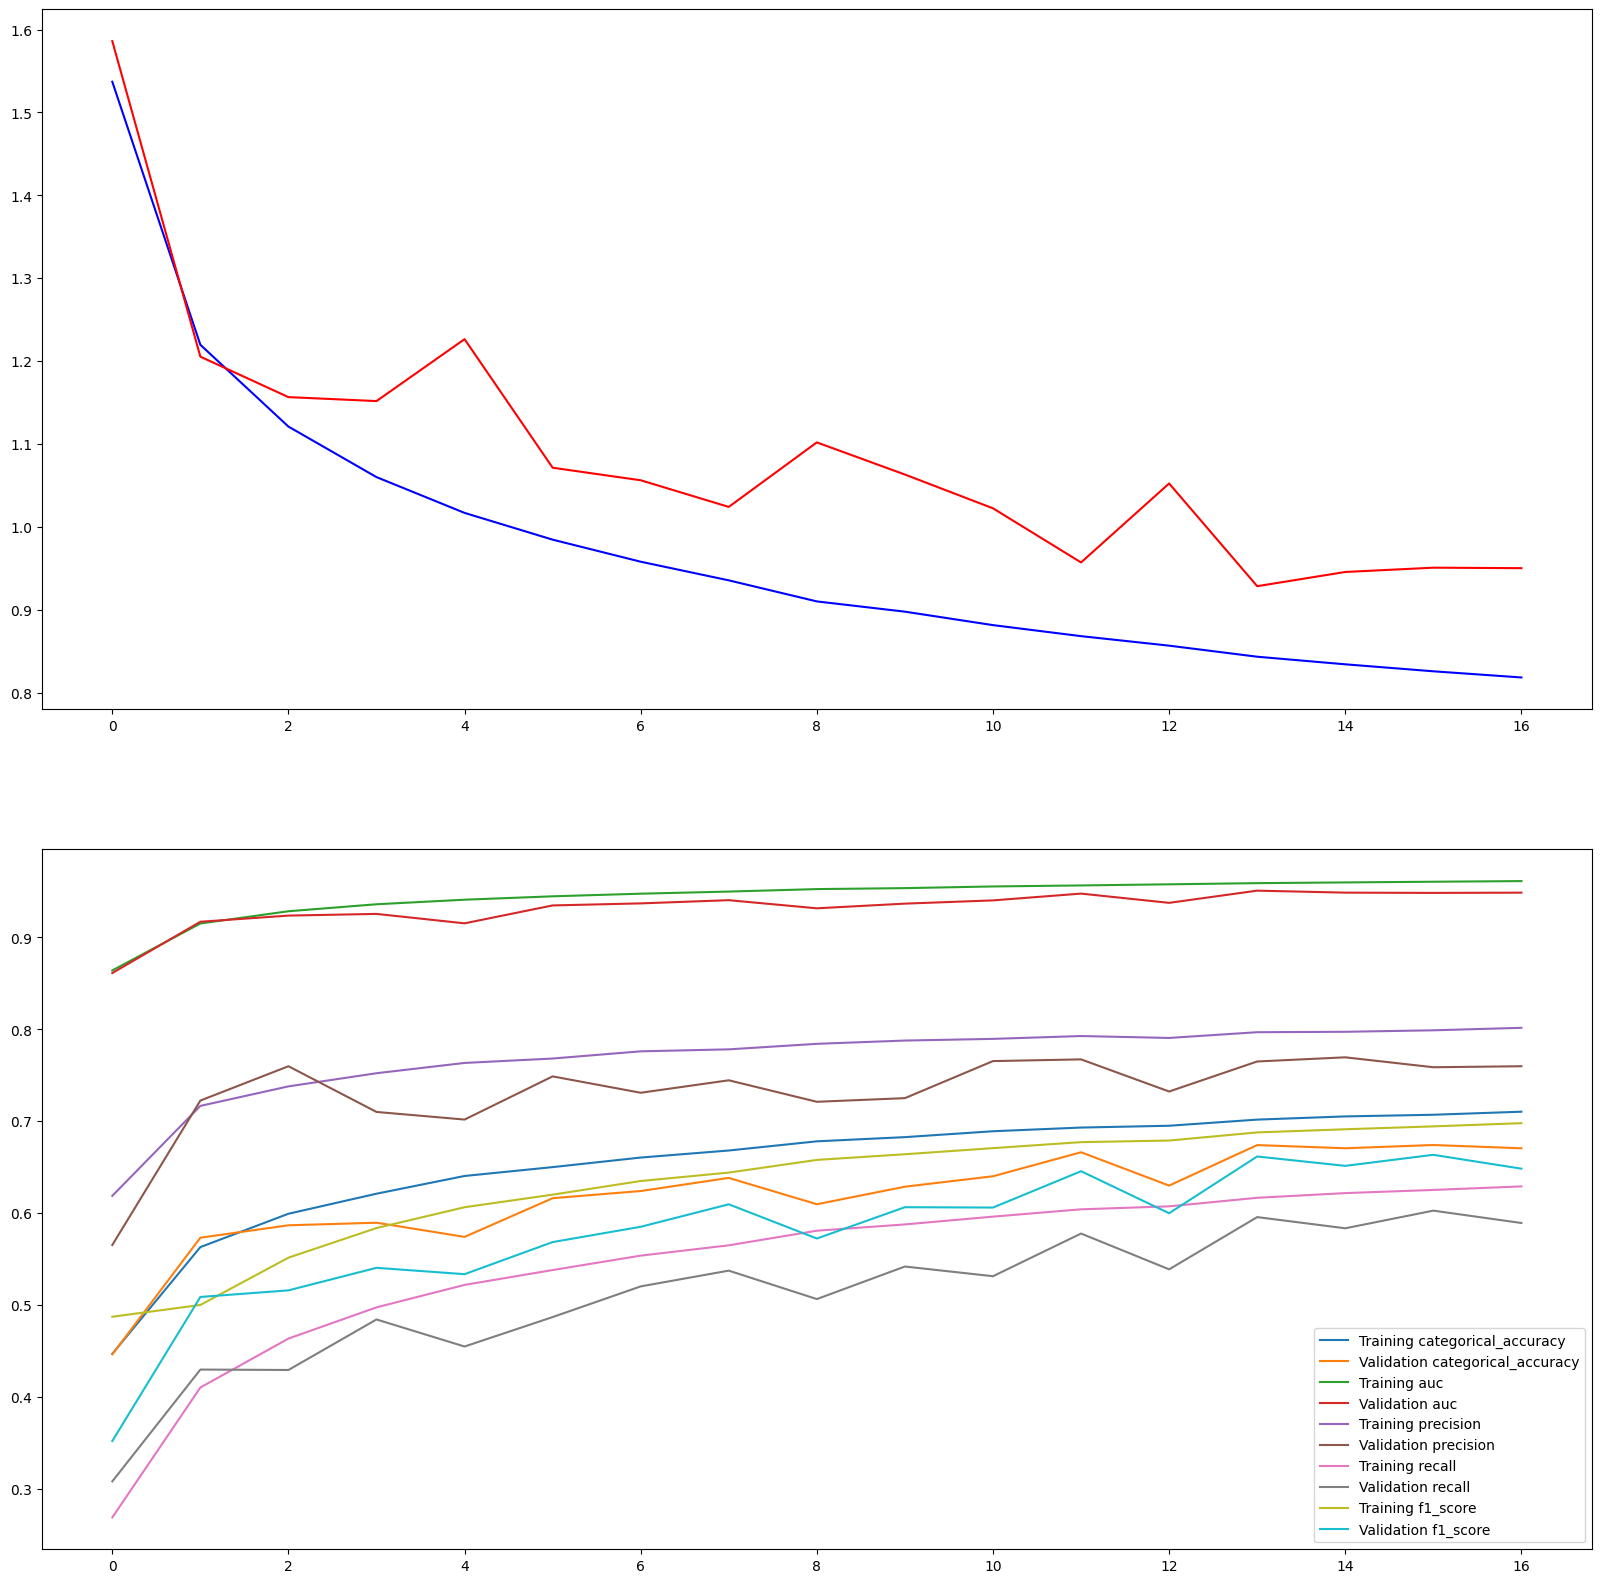

In [66]:
show_training_validation_loss_and_metrics(model12,metrics2)

In [67]:
model12.evaluate(test_it)

5625/5625 [==============================] - 59s 11ms/step - loss: 0.9593 - categorical_accuracy: 0.6670 - auc: 0.9478 - precision: 0.7573 - recall: 0.5879 - f1_score: 0.6464


[0.9592862725257874,
 0.667033314704895,
 0.9478074312210083,
 0.7572808861732483,
 0.5879444479942322,
 0.6463649868965149]

5625/5625 [==============================] - 14s 2ms/step


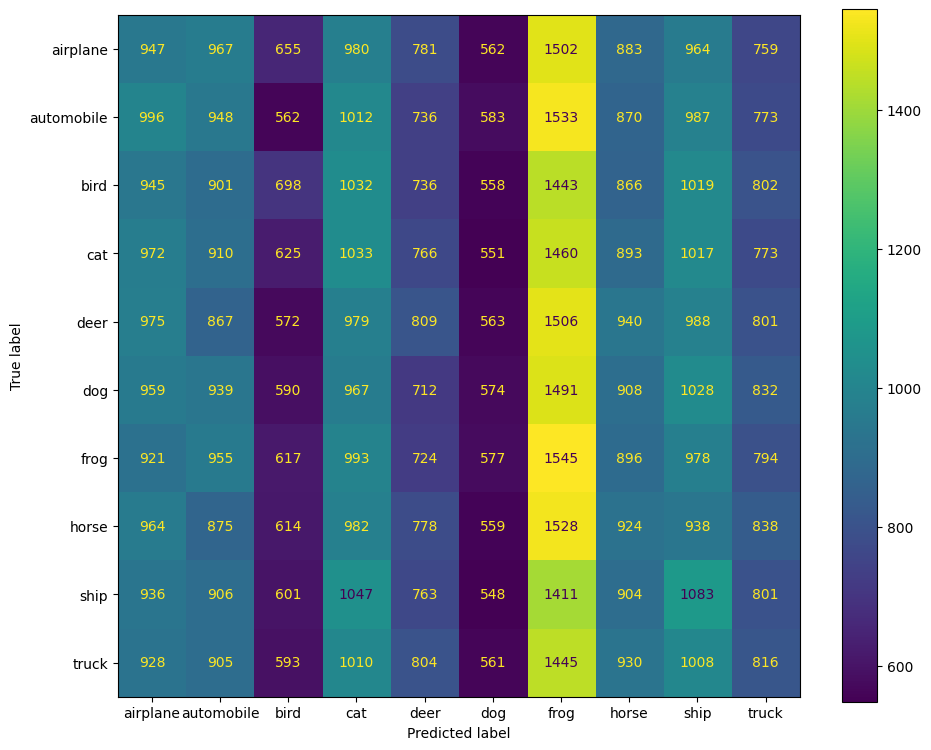

In [68]:
show_confusion_matrix(model12,test_ds,num_classes,class_names)

5625/5625 [==============================] - 13s 2ms/step


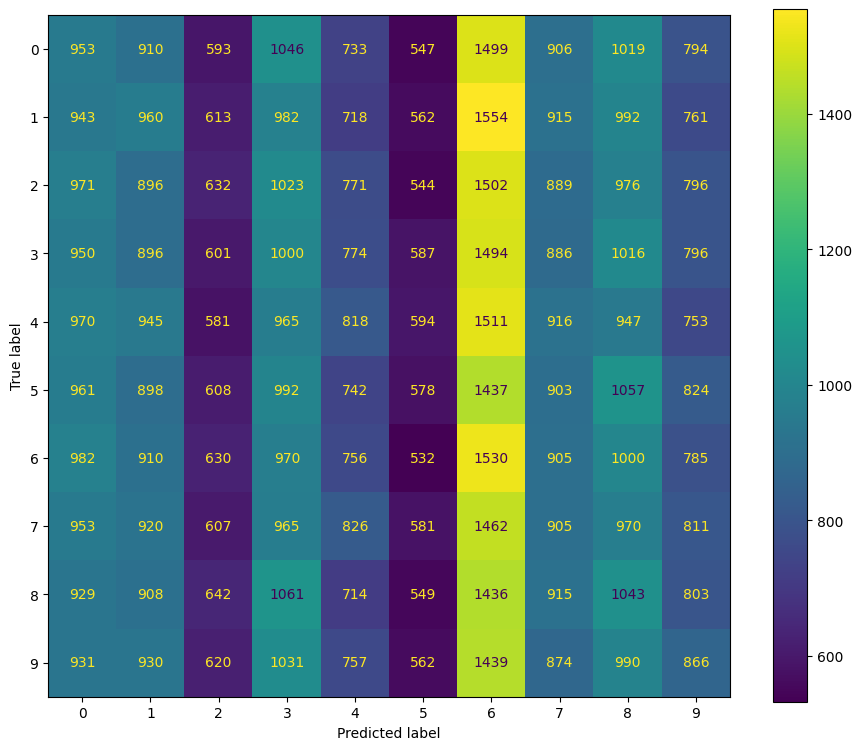

In [69]:
show_confusion_matrix_without_names(model12,test_ds,num_classes)

# Architektura drugiego modelu

In [70]:
model22 = create_model2(num_classes)

In [71]:
model22.compile( 
    loss=loss_func,
    metrics=metrics
)

In [72]:
model22.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_18 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_19 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                      

In [73]:
history = model22.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20


5625/5625 [==============================] - 123s 22ms/step - loss: 1.7152 - categorical_accuracy: 0.3771 - auc: 0.8237 - precision: 0.6114 - recall: 0.1534 - f1_score: 0.4727 - val_loss: 1.5252 - val_categorical_accuracy: 0.4375 - val_auc: 0.8646 - val_precision: 0.6398 - val_recall: 0.2404 - val_f1_score: 0.3212
Epoch 2/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.3993 - categorical_accuracy: 0.4904 - auc: 0.8872 - precision: 0.6844 - recall: 0.2915 - f1_score: 0.3787 - val_loss: 1.3313 - val_categorical_accuracy: 0.5144 - val_auc: 0.8987 - val_precision: 0.6911 - val_recall: 0.3280 - val_f1_score: 0.4035
Epoch 3/20
5625/5625 [==============================] - 123s 22ms/step - loss: 1.3049 - categorical_accuracy: 0.5301 - auc: 0.9025 - precision: 0.7091 - recall: 0.3459 - f1_score: 0.4358 - val_loss: 1.2656 - val_categorical_accuracy: 0.5419 - val_auc: 0.9085 - val_precision: 0.7084 - val_recall: 0.3810 - val_f1_score: 0.4582
Epoch 4/20
5625/5625 [========

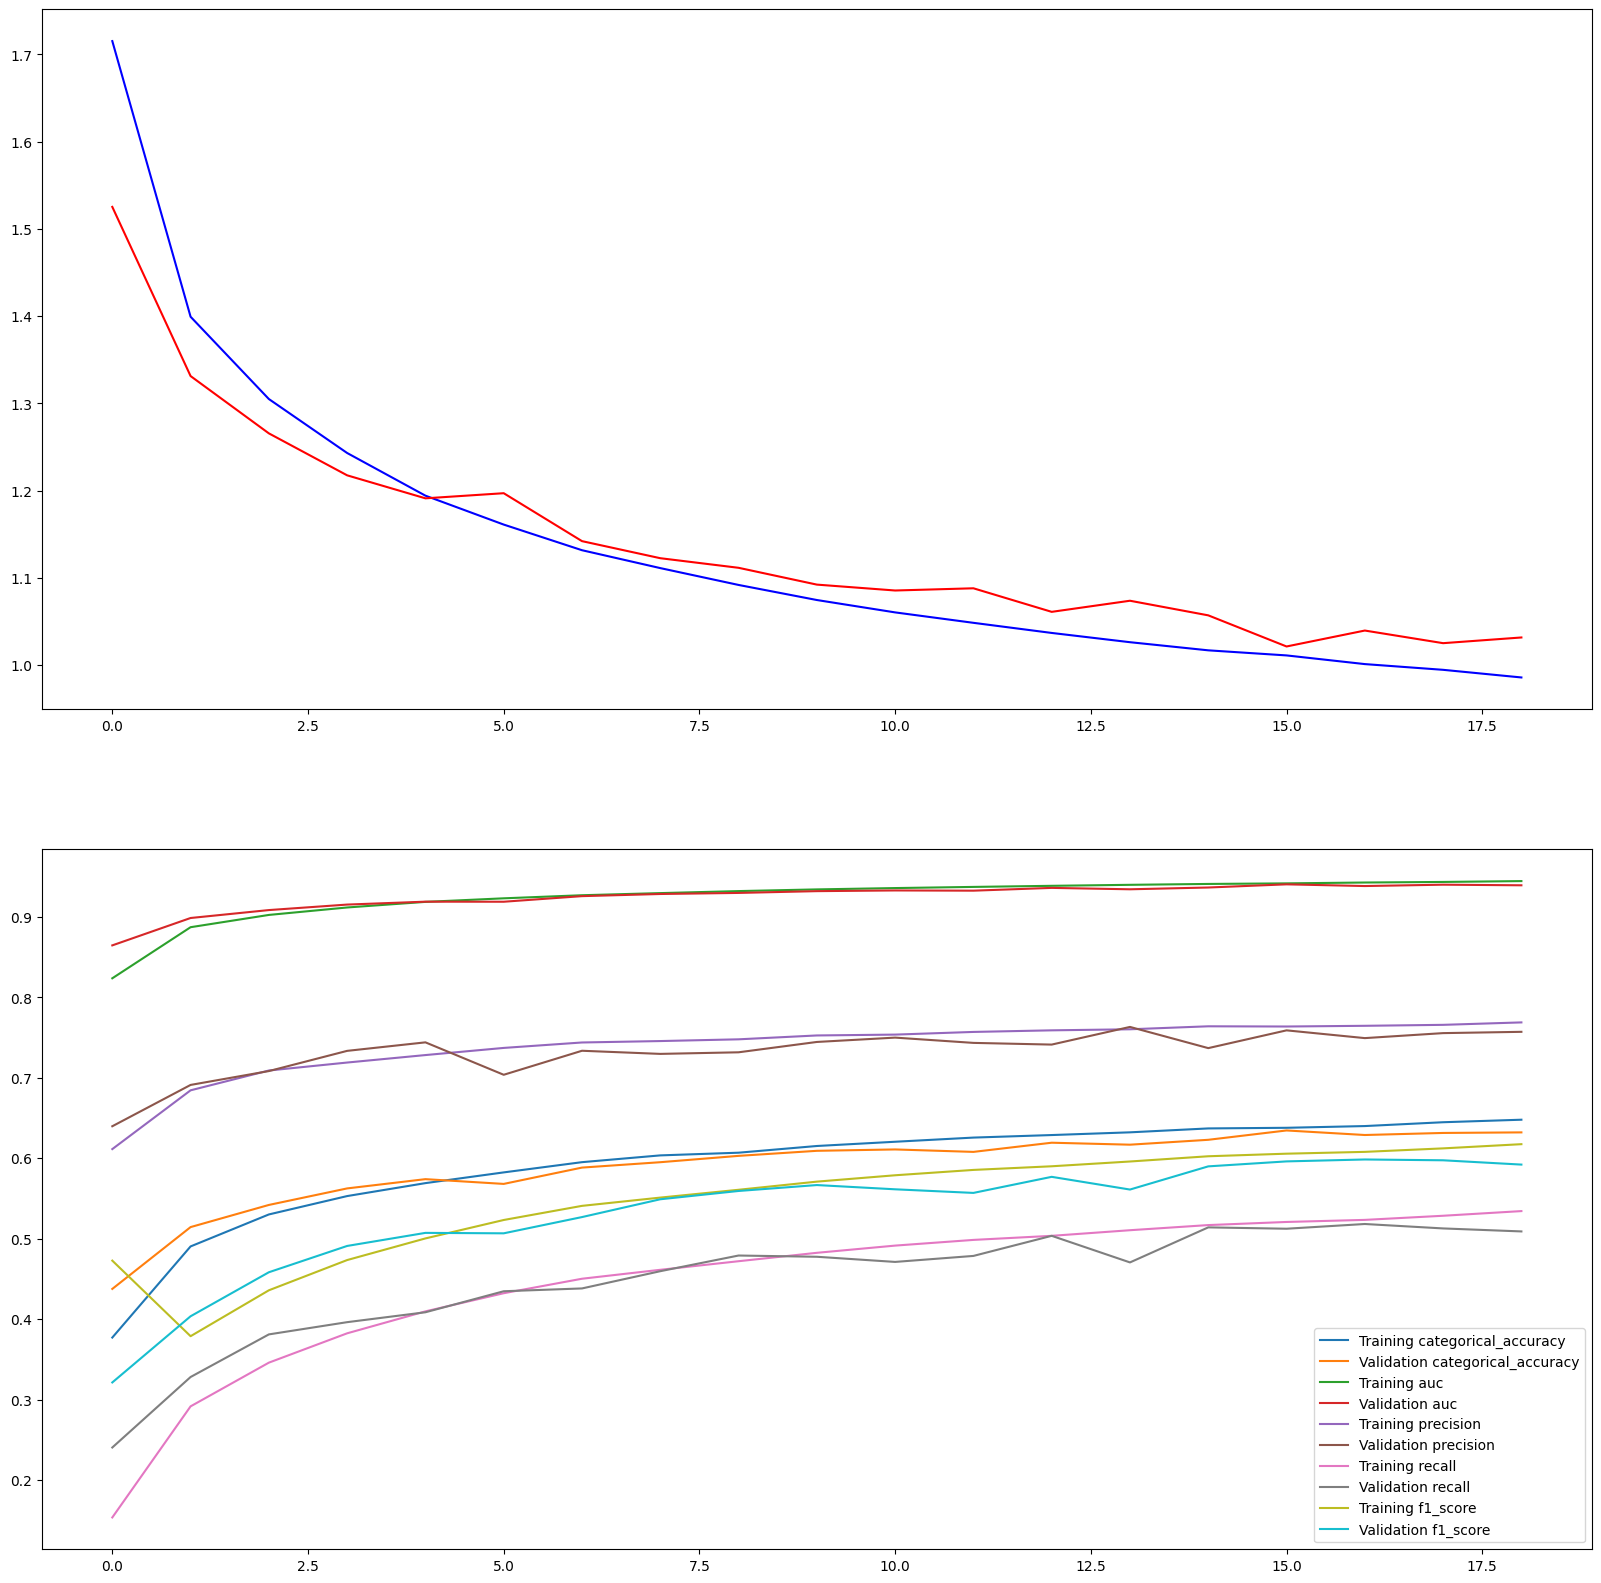

In [74]:
show_training_validation_loss_and_metrics(model22,metrics2)

In [75]:
model22.evaluate(test_it)

5625/5625 [==============================] - 90s 16ms/step - loss: 1.0433 - categorical_accuracy: 0.6291 - auc: 0.9378 - precision: 0.7563 - recall: 0.5072 - f1_score: 0.5908


[1.04332435131073,
 0.6291221976280212,
 0.9378421306610107,
 0.7562583684921265,
 0.5071889162063599,
 0.5907889008522034]

5625/5625 [==============================] - 18s 3ms/step


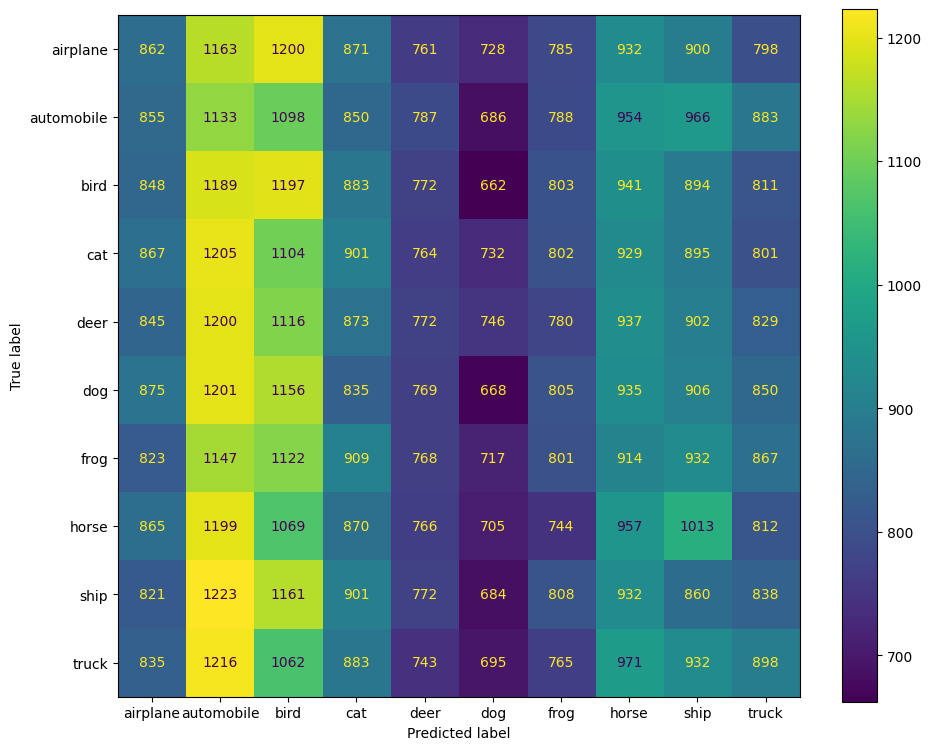

In [76]:
show_confusion_matrix(model22,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


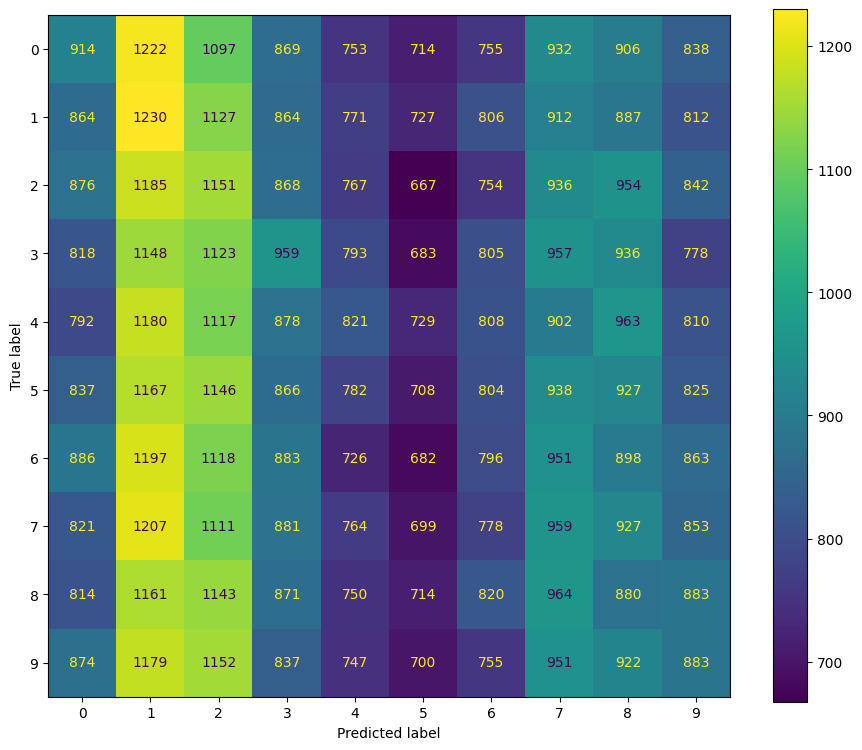

In [77]:
show_confusion_matrix_without_names(model22,test_ds,num_classes)

# Architektura trzeciego modelu

In [78]:
model32 = create_model3(num_classes)

model32.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [79]:
model32.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 layer_normalization_22 (Lay  (None, 32, 32, 256)      512       
 erNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 layer_normalization_23 (Lay  (None, 16, 16, 128)      256       
 erNormalization)                                                
                                                      

In [80]:
history = model32.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 131s 23ms/step - loss: 1.6435 - categorical_accuracy: 0.3803 - auc: 0.8385 - precision: 0.6381 - recall: 0.1483 - f1_score: 0.4335 - val_loss: 1.4045 - val_categorical_accuracy: 0.4828 - val_auc: 0.8864 - val_precision: 0.7144 - val_recall: 0.2644 - val_f1_score: 0.3464
Epoch 2/20
5625/5625 [==============================] - 128s 23ms/step - loss: 1.3601 - categorical_accuracy: 0.4984 - auc: 0.8940 - precision: 0.6918 - recall: 0.3033 - f1_score: 0.3837 - val_loss: 1.2964 - val_categorical_accuracy: 0.5222 - val_auc: 0.9044 - val_precision: 0.6831 - val_recall: 0.3681 - val_f1_score: 0.4338
Epoch 3/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.2610 - categorical_accuracy: 0.5401 - auc: 0.9094 - precision: 0.7121 - recall: 0.3648 - f1_score: 0.4467 - val_loss: 1.2103 - val_categorical_accuracy: 0.5555 - val_auc: 0.9169 - val_precision: 0.7021 - val_recall: 0.4104 - val_f1_score: 0.4810
Epoch 4/20
5625/562

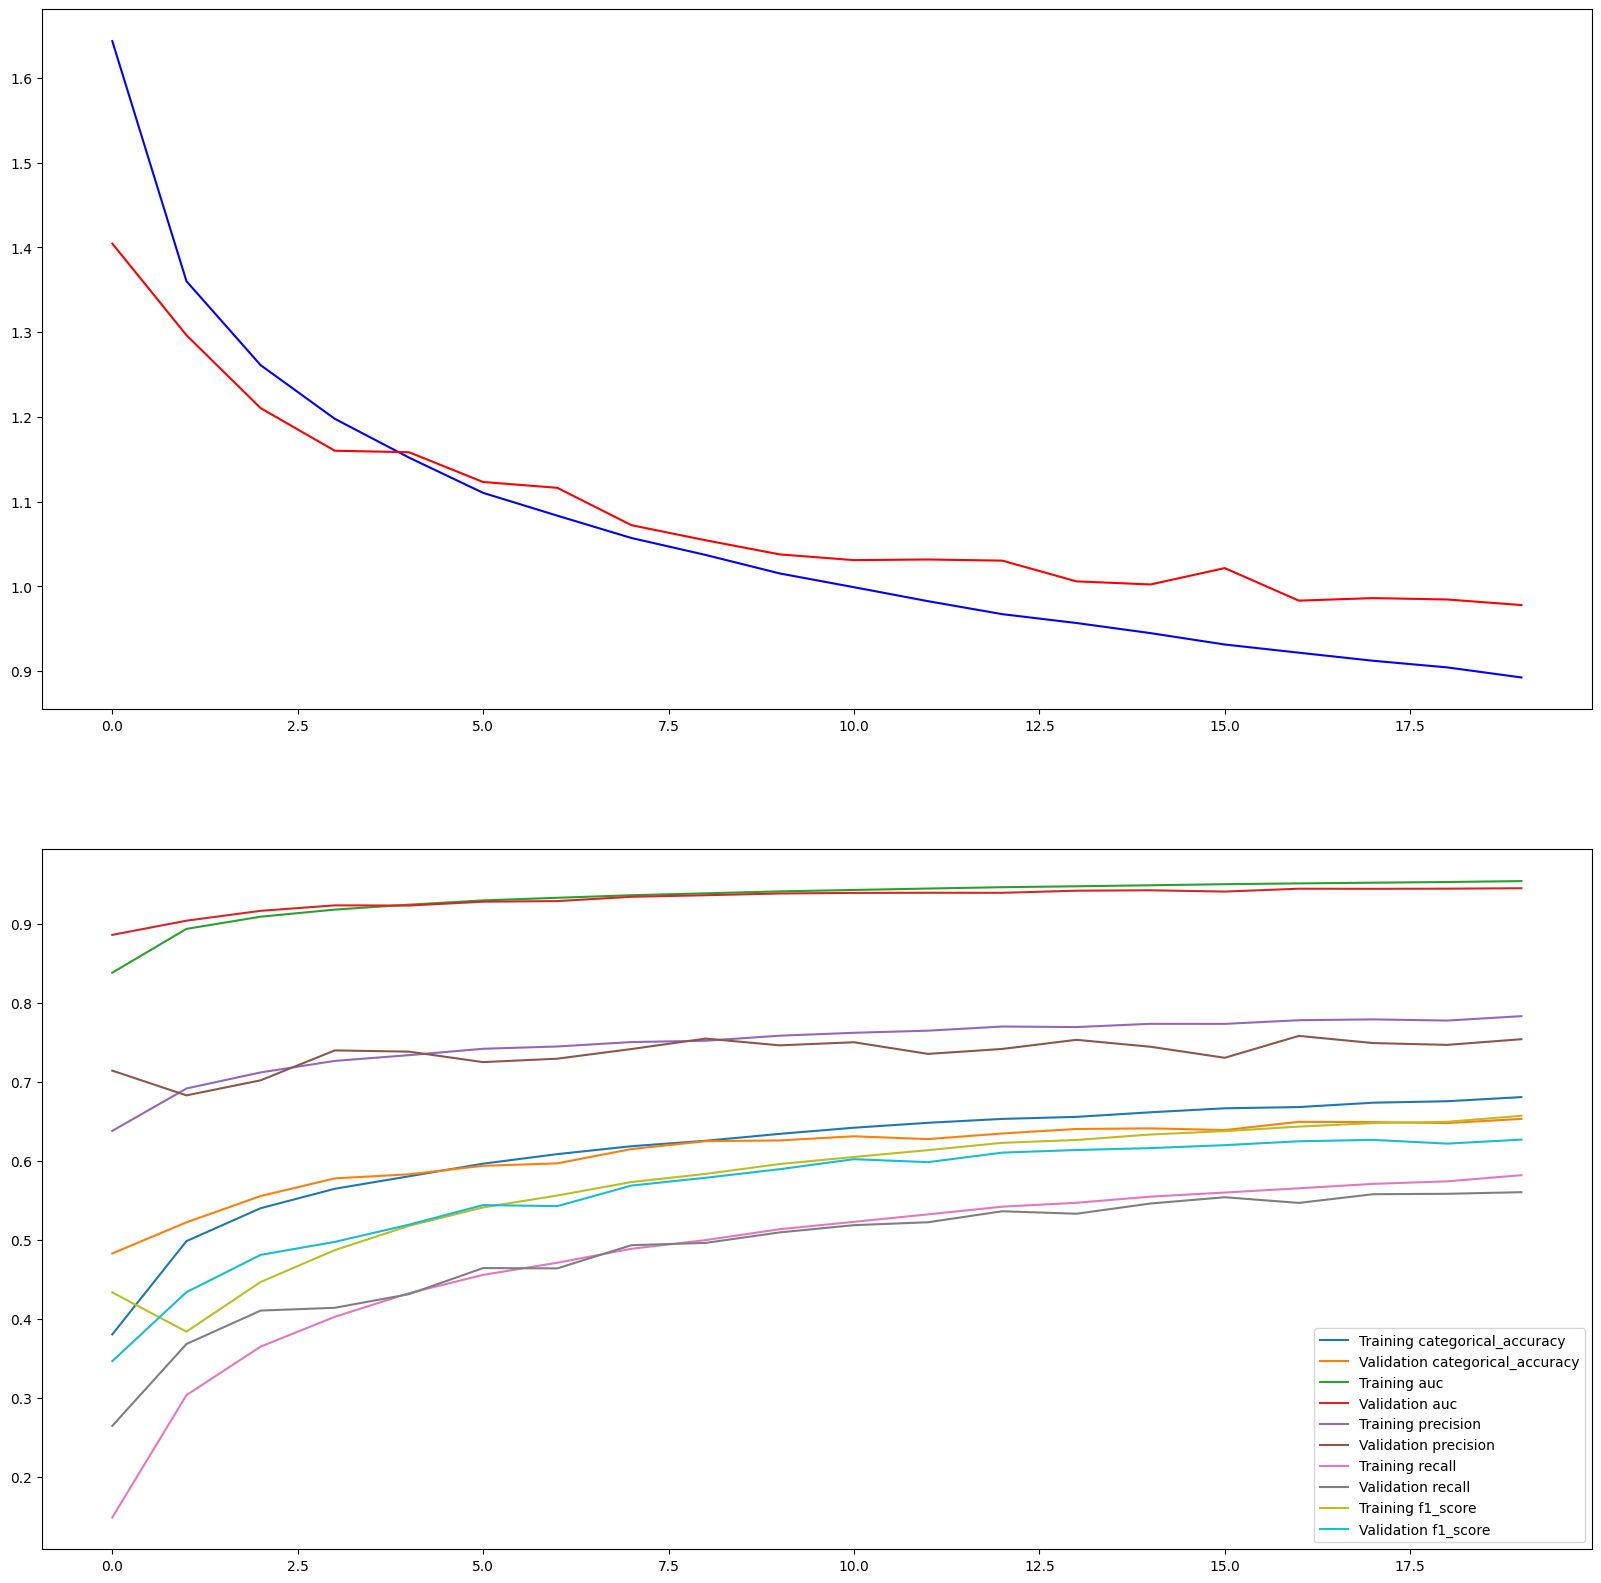

In [81]:
show_training_validation_loss_and_metrics(model32,metrics2)

In [82]:
model32.evaluate(test_it)

5625/5625 [==============================] - 62s 11ms/step - loss: 0.9916 - categorical_accuracy: 0.6494 - auc: 0.9441 - precision: 0.7490 - recall: 0.5587 - f1_score: 0.6246


[0.9915706515312195,
 0.6494444608688354,
 0.944057285785675,
 0.7490428686141968,
 0.5586777925491333,
 0.6246188879013062]

5625/5625 [==============================] - 18s 3ms/step


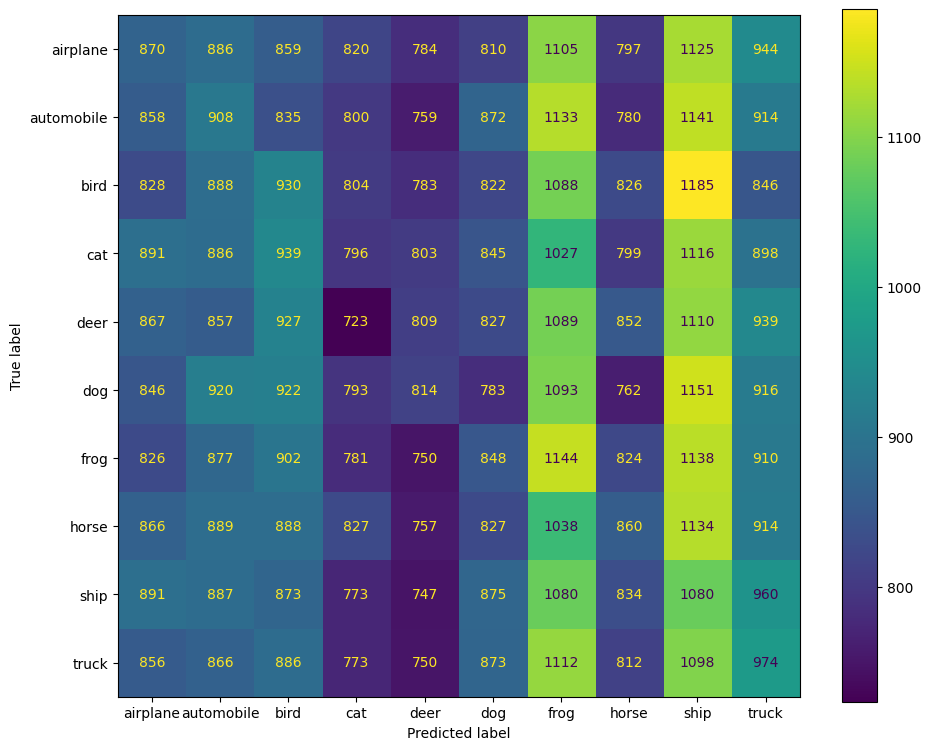

In [83]:
show_confusion_matrix(model32,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


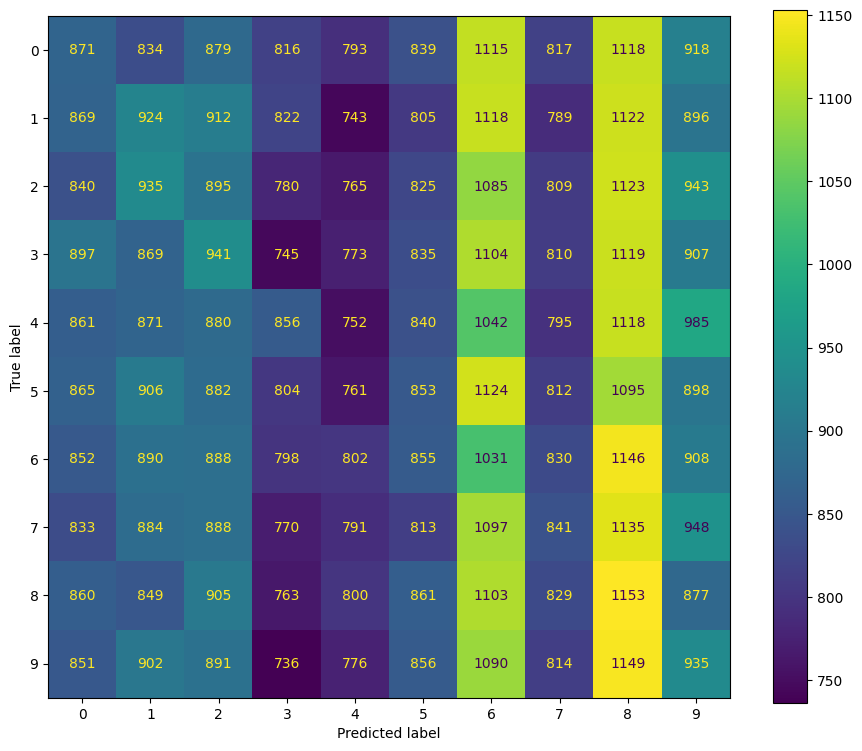

In [84]:
show_confusion_matrix_without_names(model32,test_ds,num_classes)

# Ziarno 7654

In [85]:
SEED = 7654

tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [86]:
model13 = create_model1(num_classes)

In [87]:
model13.compile( 
    loss=loss_func,
    metrics=metrics
)

In [88]:

model13.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                      

In [89]:
history = model13.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.5377 - categorical_accuracy: 0.4472 - auc: 0.8641 - precision: 0.6134 - recall: 0.2669 - f1_score: 0.5007 - val_loss: 1.5985 - val_categorical_accuracy: 0.4387 - val_auc: 0.8586 - val_precision: 0.5783 - val_recall: 0.3052 - val_f1_score: 0.3431
Epoch 2/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.2266 - categorical_accuracy: 0.5573 - auc: 0.9143 - precision: 0.7113 - recall: 0.4015 - f1_score: 0.4899 - val_loss: 1.3078 - val_categorical_accuracy: 0.5289 - val_auc: 0.9033 - val_precision: 0.6705 - val_recall: 0.3939 - val_f1_score: 0.4502
Epoch 3/20
5625/5625 [==============================] - 121s 21ms/step - loss: 1.1258 - categorical_accuracy: 0.5973 - auc: 0.9278 - precision: 0.7400 - recall: 0.4608 - f1_score: 0.5498 - val_loss: 1.1666 - val_categorical_accuracy: 0.5861 - val_auc: 0.9219 - val_precision: 0.7554 - val_recall: 0.4328 - val_f1_score: 0.5192
Epoch 4/20
5625/562

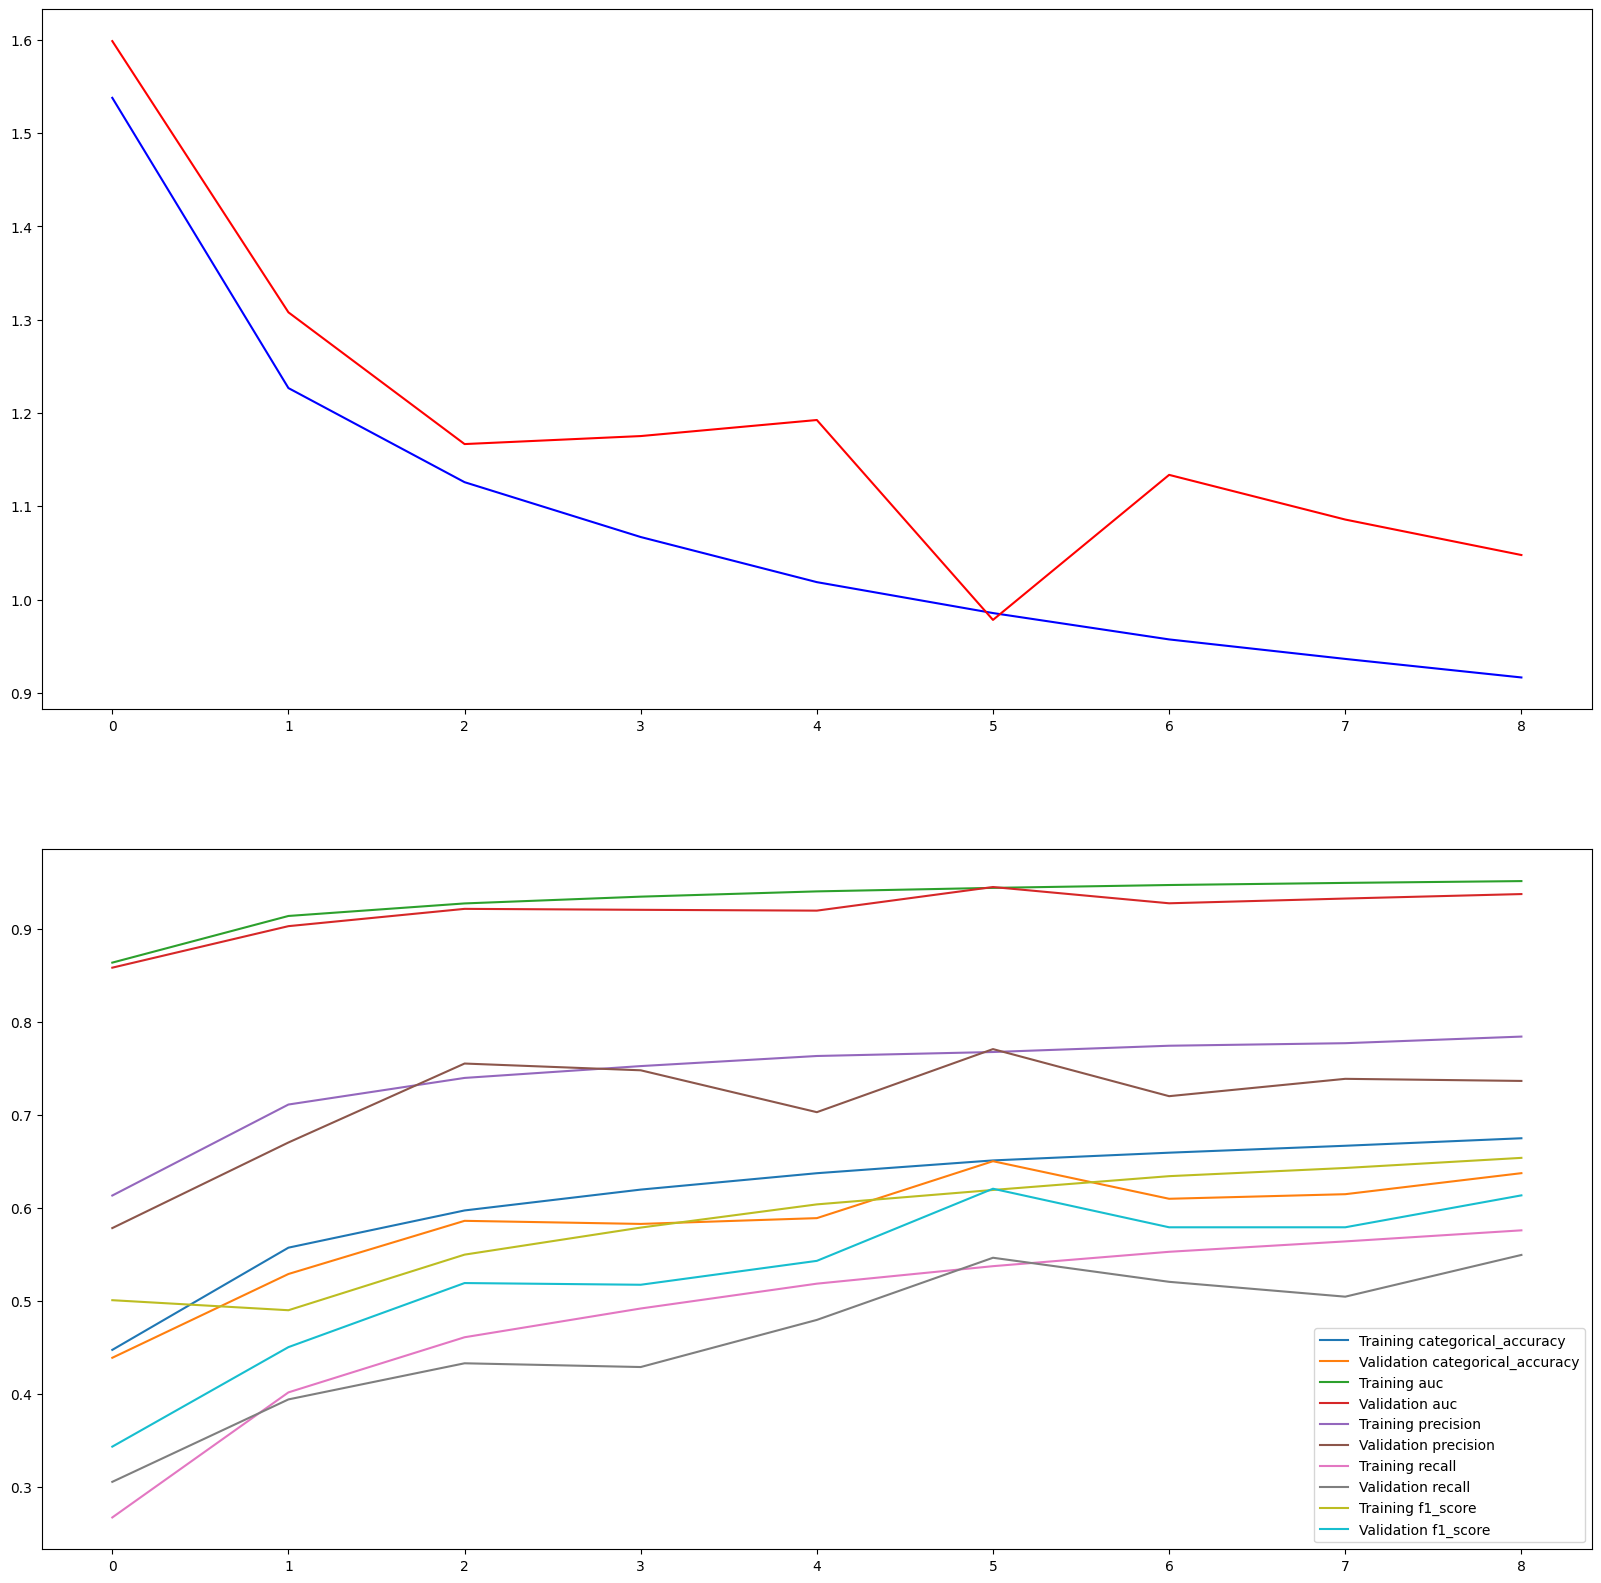

In [90]:
show_training_validation_loss_and_metrics(model13,metrics2)

In [91]:
model13.evaluate(test_it)

5625/5625 [==============================] - 62s 11ms/step - loss: 1.0538 - categorical_accuracy: 0.6390 - auc: 0.9371 - precision: 0.7387 - recall: 0.5496 - f1_score: 0.6146


[1.0538398027420044,
 0.6389666795730591,
 0.9370784163475037,
 0.7386940717697144,
 0.5495555400848389,
 0.6145617961883545]

5625/5625 [==============================] - 15s 3ms/step


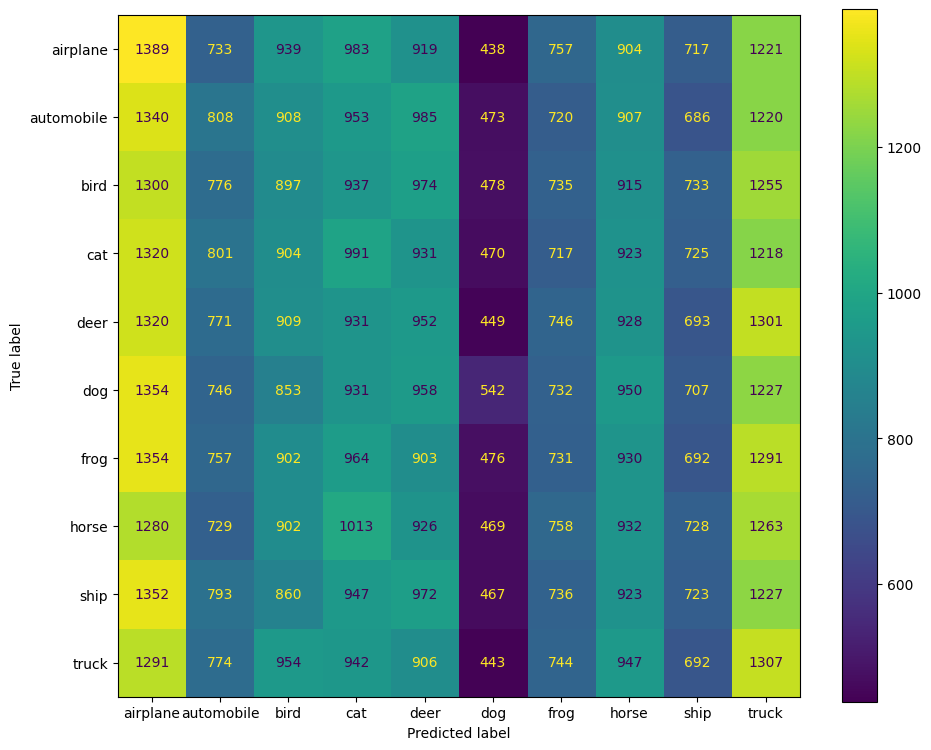

In [92]:
show_confusion_matrix(model13,test_ds,num_classes,class_names)

5625/5625 [==============================] - 14s 3ms/step


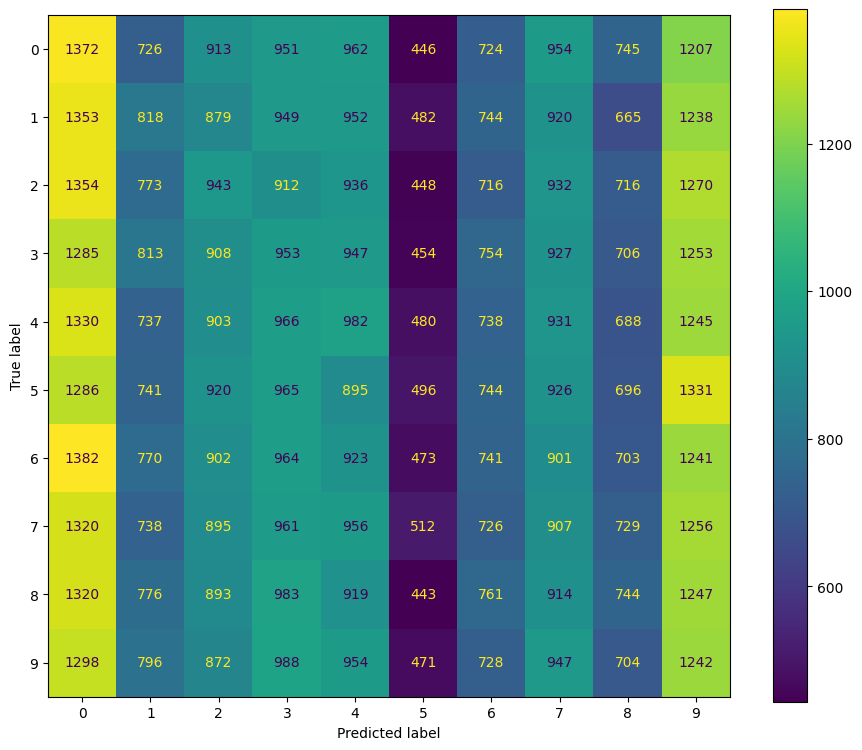

In [93]:
show_confusion_matrix_without_names(model13,test_ds,num_classes)

# Architektura drugiego modelu

In [94]:
model23 = create_model2(num_classes)

In [95]:
model23.compile( 
    loss=loss_func,
    metrics=metrics
)

In [96]:
model23.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_27 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_9 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_28 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [97]:
history = model23.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.7038 - categorical_accuracy: 0.3834 - auc: 0.8283 - precision: 0.6076 - recall: 0.1635 - f1_score: 0.4564 - val_loss: 1.4470 - val_categorical_accuracy: 0.4761 - val_auc: 0.8791 - val_precision: 0.6744 - val_recall: 0.2631 - val_f1_score: 0.3407
Epoch 2/20
5625/5625 [==============================] - 124s 22ms/step - loss: 1.3792 - categorical_accuracy: 0.4990 - auc: 0.8906 - precision: 0.6908 - recall: 0.3034 - f1_score: 0.3905 - val_loss: 1.3516 - val_categorical_accuracy: 0.5058 - val_auc: 0.8952 - val_precision: 0.6972 - val_recall: 0.3116 - val_f1_score: 0.3904
Epoch 3/20
5625/5625 [==============================] - 122s 22ms/step - loss: 1.2823 - categorical_accuracy: 0.5358 - auc: 0.9059 - precision: 0.7100 - recall: 0.3577 - f1_score: 0.4467 - val_loss: 1.2473 - val_categorical_accuracy: 0.5489 - val_auc: 0.9113 - val_precision: 0.7457 - val_recall: 0.3584 - val_f1_score: 0.4427
Epoch 4/20
5625/562

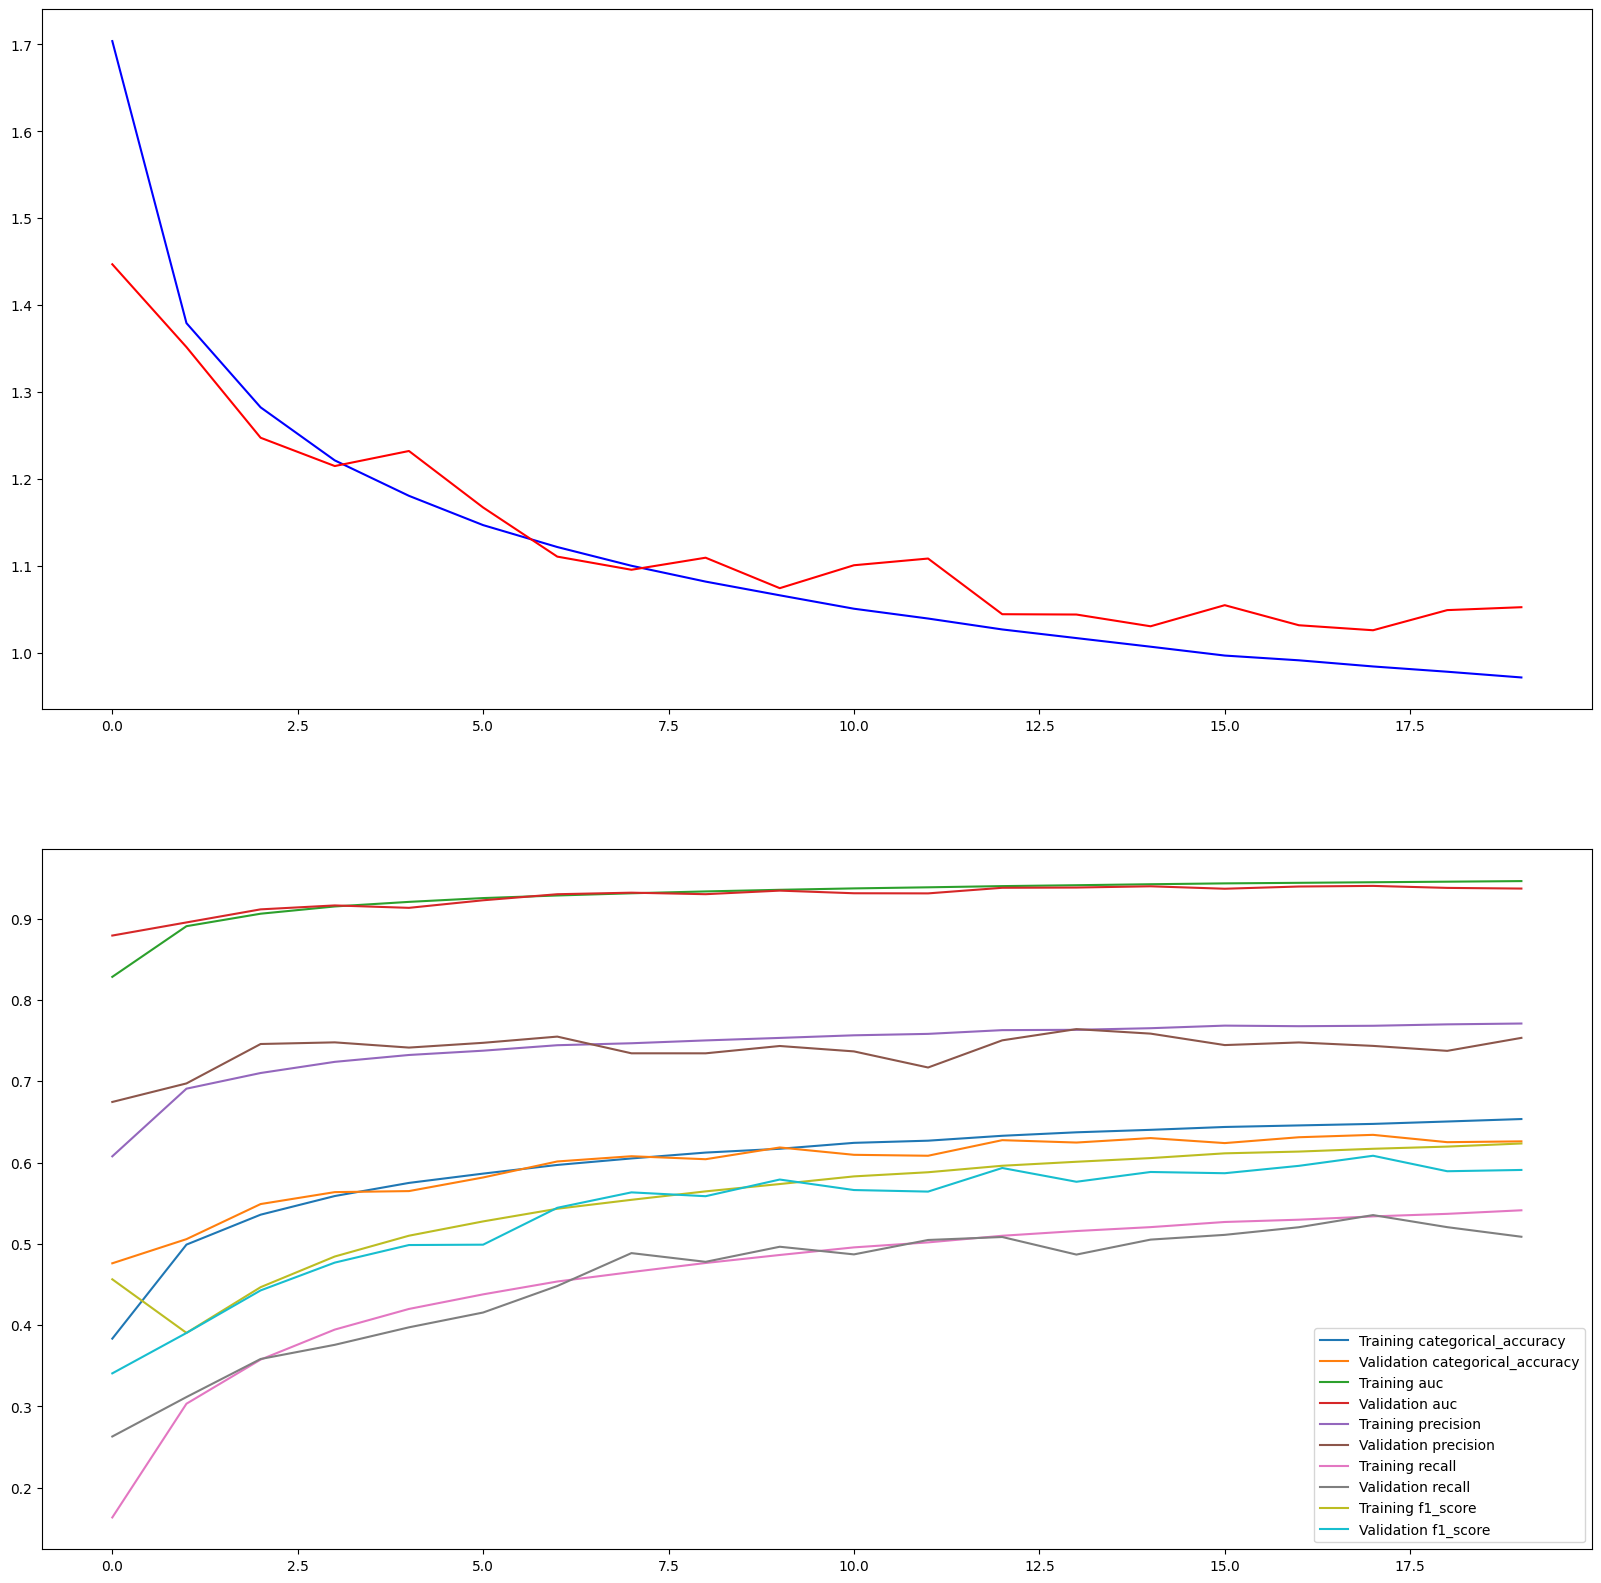

In [98]:
show_training_validation_loss_and_metrics(model23,metrics2)

In [99]:
model23.evaluate(test_it)

5625/5625 [==============================] - 59s 11ms/step - loss: 1.0592 - categorical_accuracy: 0.6253 - auc: 0.9359 - precision: 0.7510 - recall: 0.5083 - f1_score: 0.5900


[1.059219241142273,
 0.6252666711807251,
 0.9358950257301331,
 0.7509973645210266,
 0.5082666873931885,
 0.5899531841278076]

5625/5625 [==============================] - 21s 4ms/step


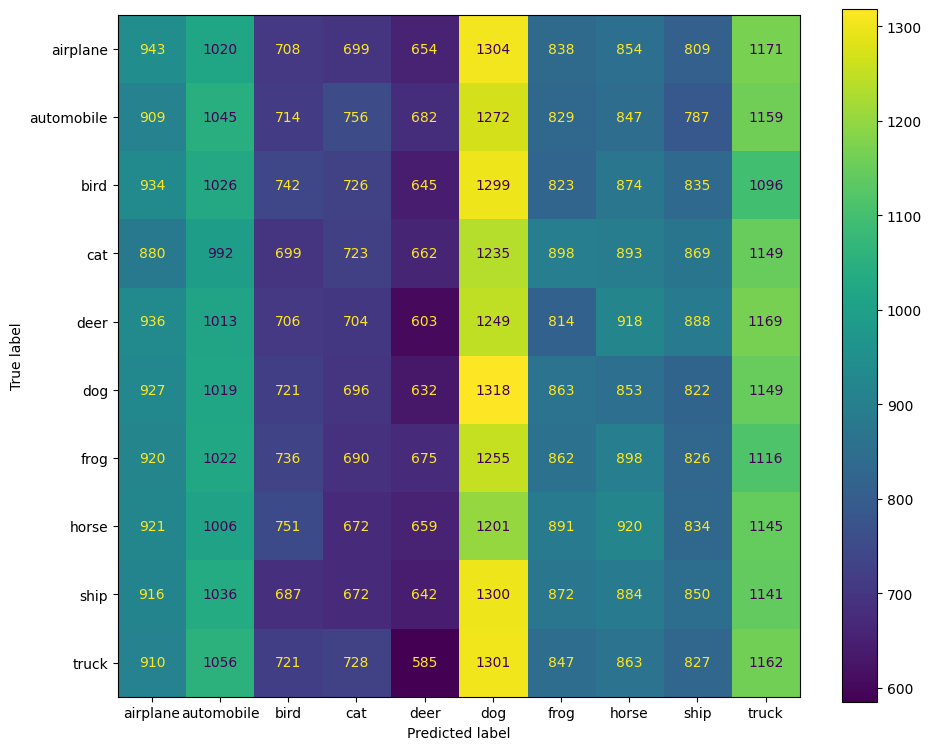

In [100]:
show_confusion_matrix(model23,test_ds,num_classes,class_names)

5625/5625 [==============================] - 17s 3ms/step


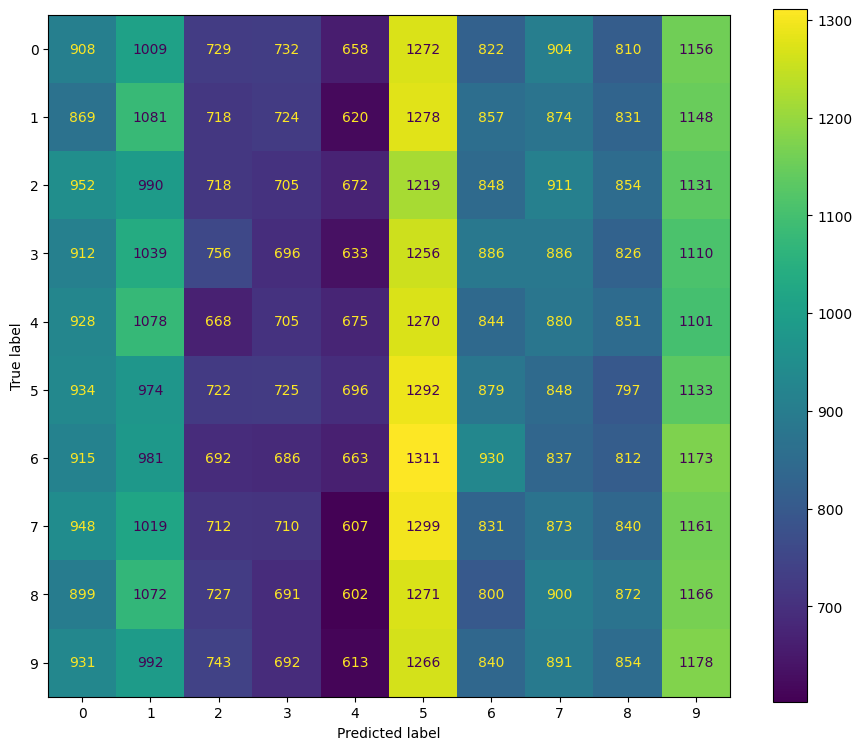

In [101]:
show_confusion_matrix_without_names(model23,test_ds,num_classes)

# Architektura trzeciego modelu

In [102]:
model33 = create_model3(num_classes)

model33.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [103]:
history = model33.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 133s 23ms/step - loss: 1.6364 - categorical_accuracy: 0.3840 - auc: 0.8401 - precision: 0.6419 - recall: 0.1534 - f1_score: 0.4348 - val_loss: 1.4429 - val_categorical_accuracy: 0.4602 - val_auc: 0.8802 - val_precision: 0.6544 - val_recall: 0.2736 - val_f1_score: 0.3367
Epoch 2/20
5625/5625 [==============================] - 132s 24ms/step - loss: 1.3631 - categorical_accuracy: 0.4963 - auc: 0.8934 - precision: 0.6893 - recall: 0.3004 - f1_score: 0.3786 - val_loss: 1.2884 - val_categorical_accuracy: 0.5271 - val_auc: 0.9064 - val_precision: 0.6636 - val_recall: 0.3791 - val_f1_score: 0.4306
Epoch 3/20
5625/5625 [==============================] - 133s 24ms/step - loss: 1.2550 - categorical_accuracy: 0.5402 - auc: 0.9103 - precision: 0.7134 - recall: 0.3674 - f1_score: 0.4501 - val_loss: 1.2191 - val_categorical_accuracy: 0.5575 - val_auc: 0.9153 - val_precision: 0.7263 - val_recall: 0.3905 - val_f1_score: 0.4816
Epoch 4/20
5625/562

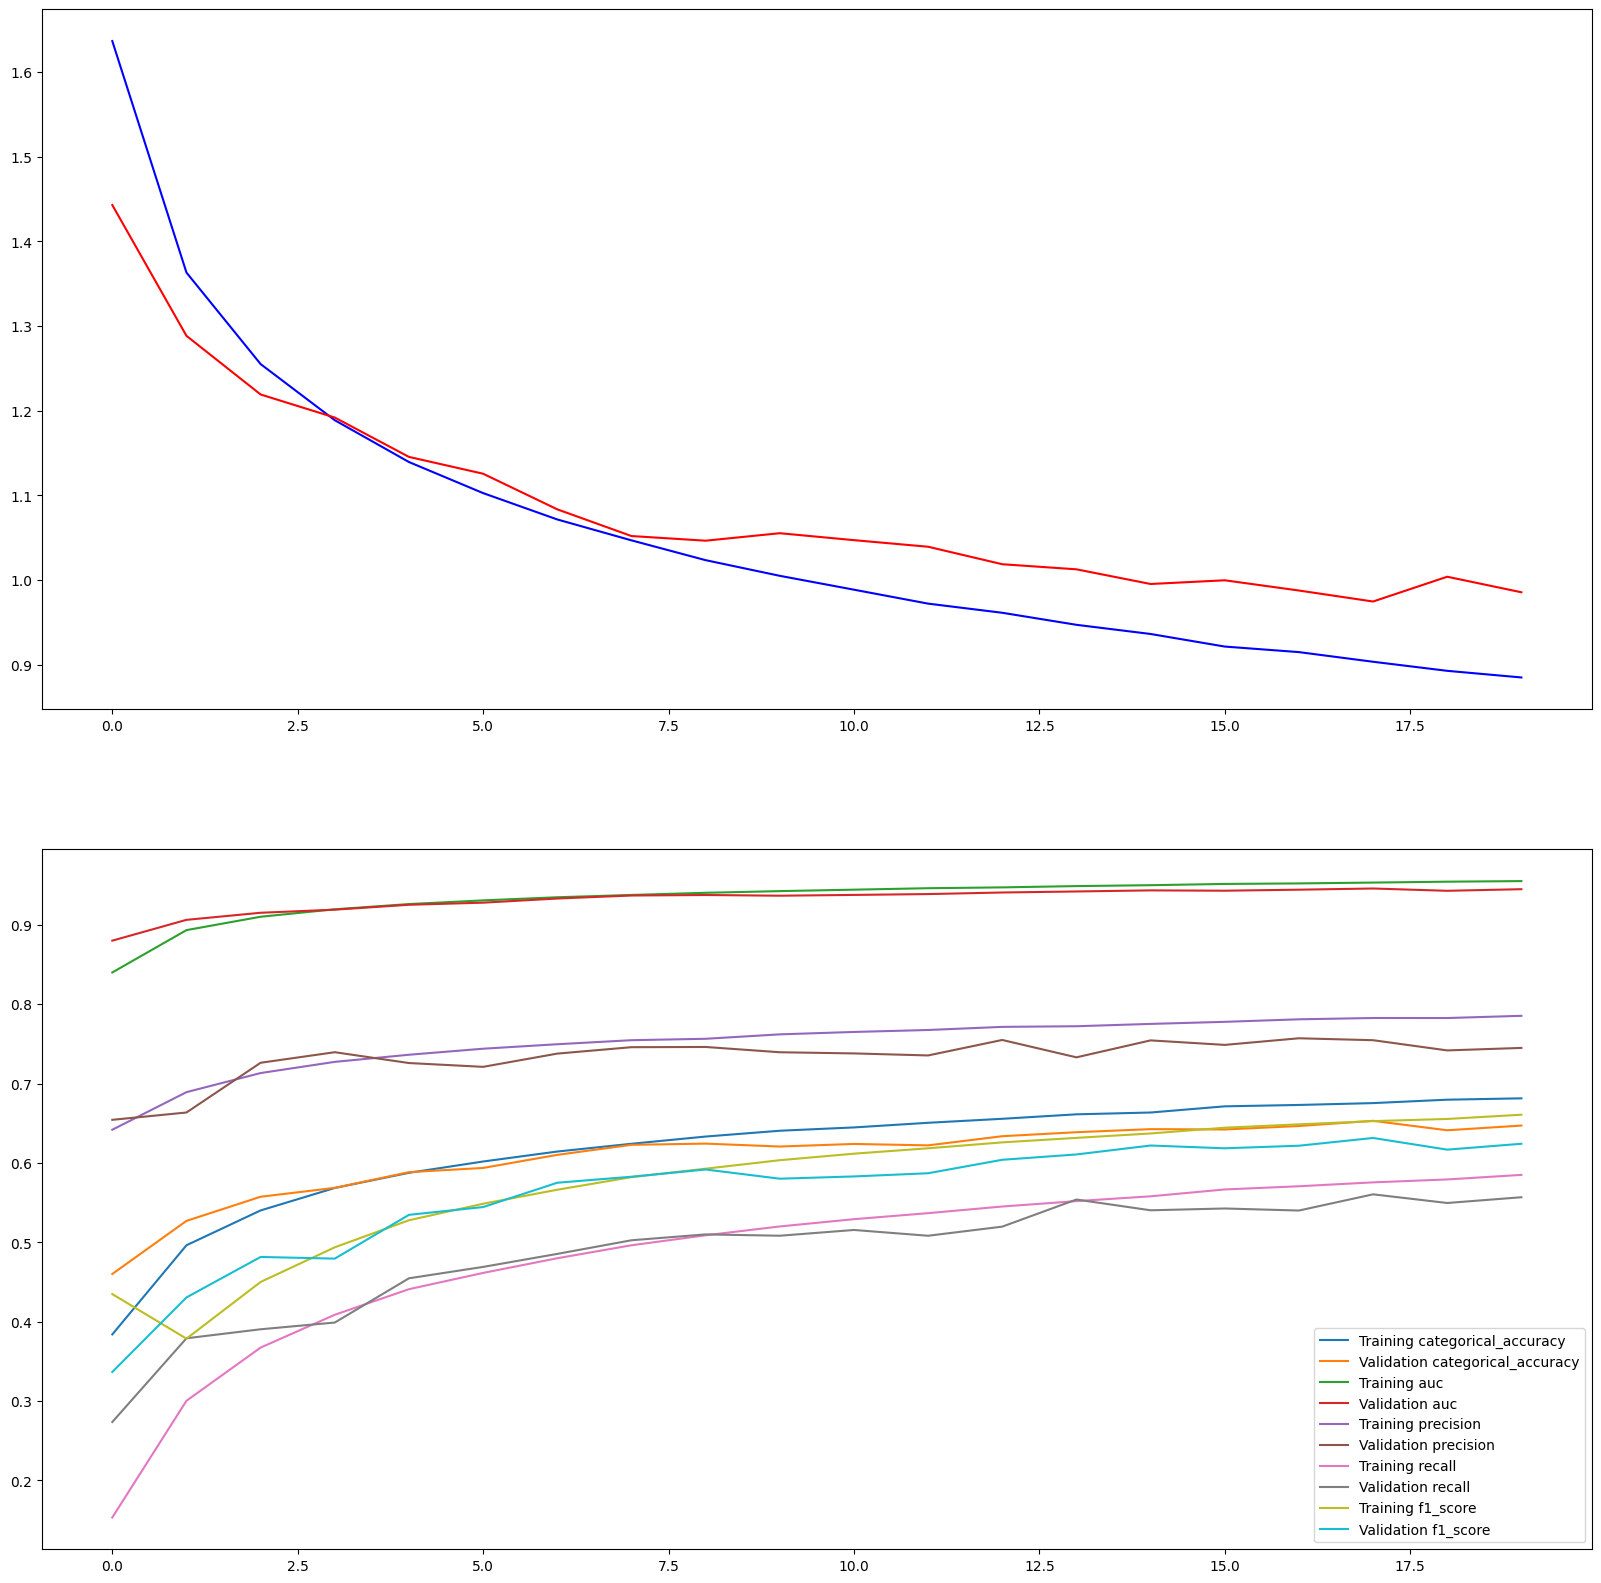

In [104]:
show_training_validation_loss_and_metrics(model33,metrics2)

In [105]:
model33.evaluate(test_it)

5625/5625 [==============================] - 65s 12ms/step - loss: 0.9973 - categorical_accuracy: 0.6426 - auc: 0.9437 - precision: 0.7424 - recall: 0.5540 - f1_score: 0.6215


[0.9973132014274597,
 0.6425999999046326,
 0.9436601996421814,
 0.7423955798149109,
 0.5540333390235901,
 0.6214869022369385]

5625/5625 [==============================] - 19s 3ms/step


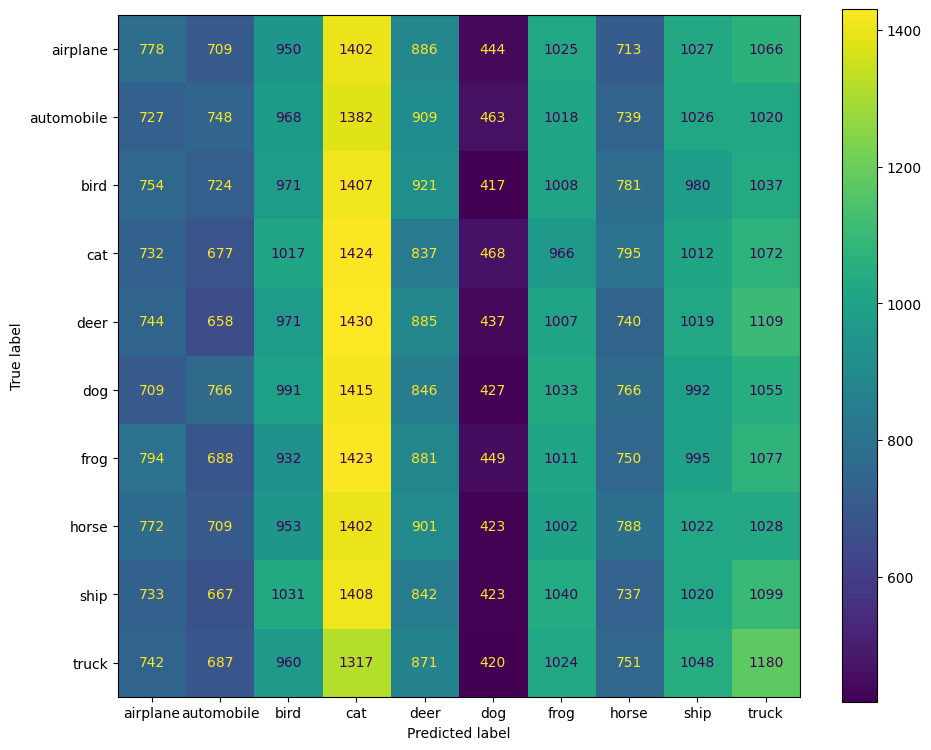

In [106]:
show_confusion_matrix(model33,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


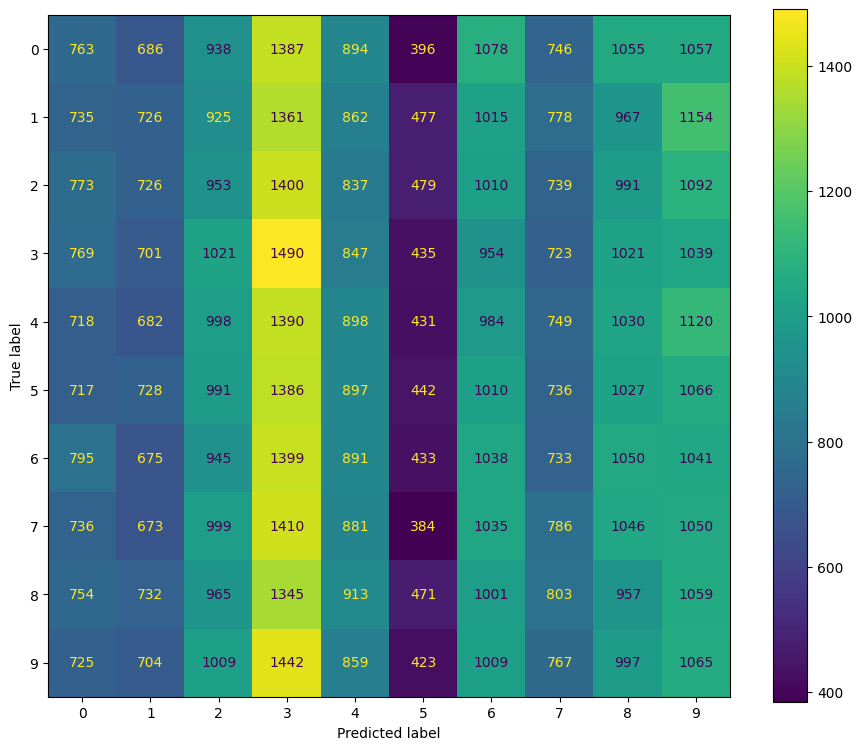

In [107]:
show_confusion_matrix_without_names(model33,test_ds,num_classes)

# Ziarno 313

In [108]:
SEED = 313
tf.random.set_seed(SEED)

# Architektura pierwszego modelu

In [109]:
model14 = create_model1(num_classes)

In [110]:
model14.compile( 
    loss=loss_func,
    metrics=metrics
)

In [111]:
model14.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_16 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_17 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

In [112]:
history = model14.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20


5625/5625 [==============================] - 127s 22ms/step - loss: 1.5334 - categorical_accuracy: 0.4477 - auc: 0.8648 - precision: 0.6172 - recall: 0.2700 - f1_score: 0.5030 - val_loss: 1.2951 - val_categorical_accuracy: 0.5301 - val_auc: 0.9046 - val_precision: 0.7121 - val_recall: 0.3414 - val_f1_score: 0.4216
Epoch 2/20
5625/5625 [==============================] - 124s 22ms/step - loss: 1.2224 - categorical_accuracy: 0.5595 - auc: 0.9148 - precision: 0.7167 - recall: 0.4067 - f1_score: 0.4958 - val_loss: 1.2377 - val_categorical_accuracy: 0.5577 - val_auc: 0.9126 - val_precision: 0.7112 - val_recall: 0.4128 - val_f1_score: 0.4772
Epoch 3/20
5625/5625 [==============================] - 127s 23ms/step - loss: 1.1286 - categorical_accuracy: 0.5948 - auc: 0.9276 - precision: 0.7361 - recall: 0.4577 - f1_score: 0.5457 - val_loss: 1.0976 - val_categorical_accuracy: 0.6069 - val_auc: 0.9314 - val_precision: 0.7588 - val_recall: 0.4585 - val_f1_score: 0.5399
Epoch 4/20
5625/5625 [========

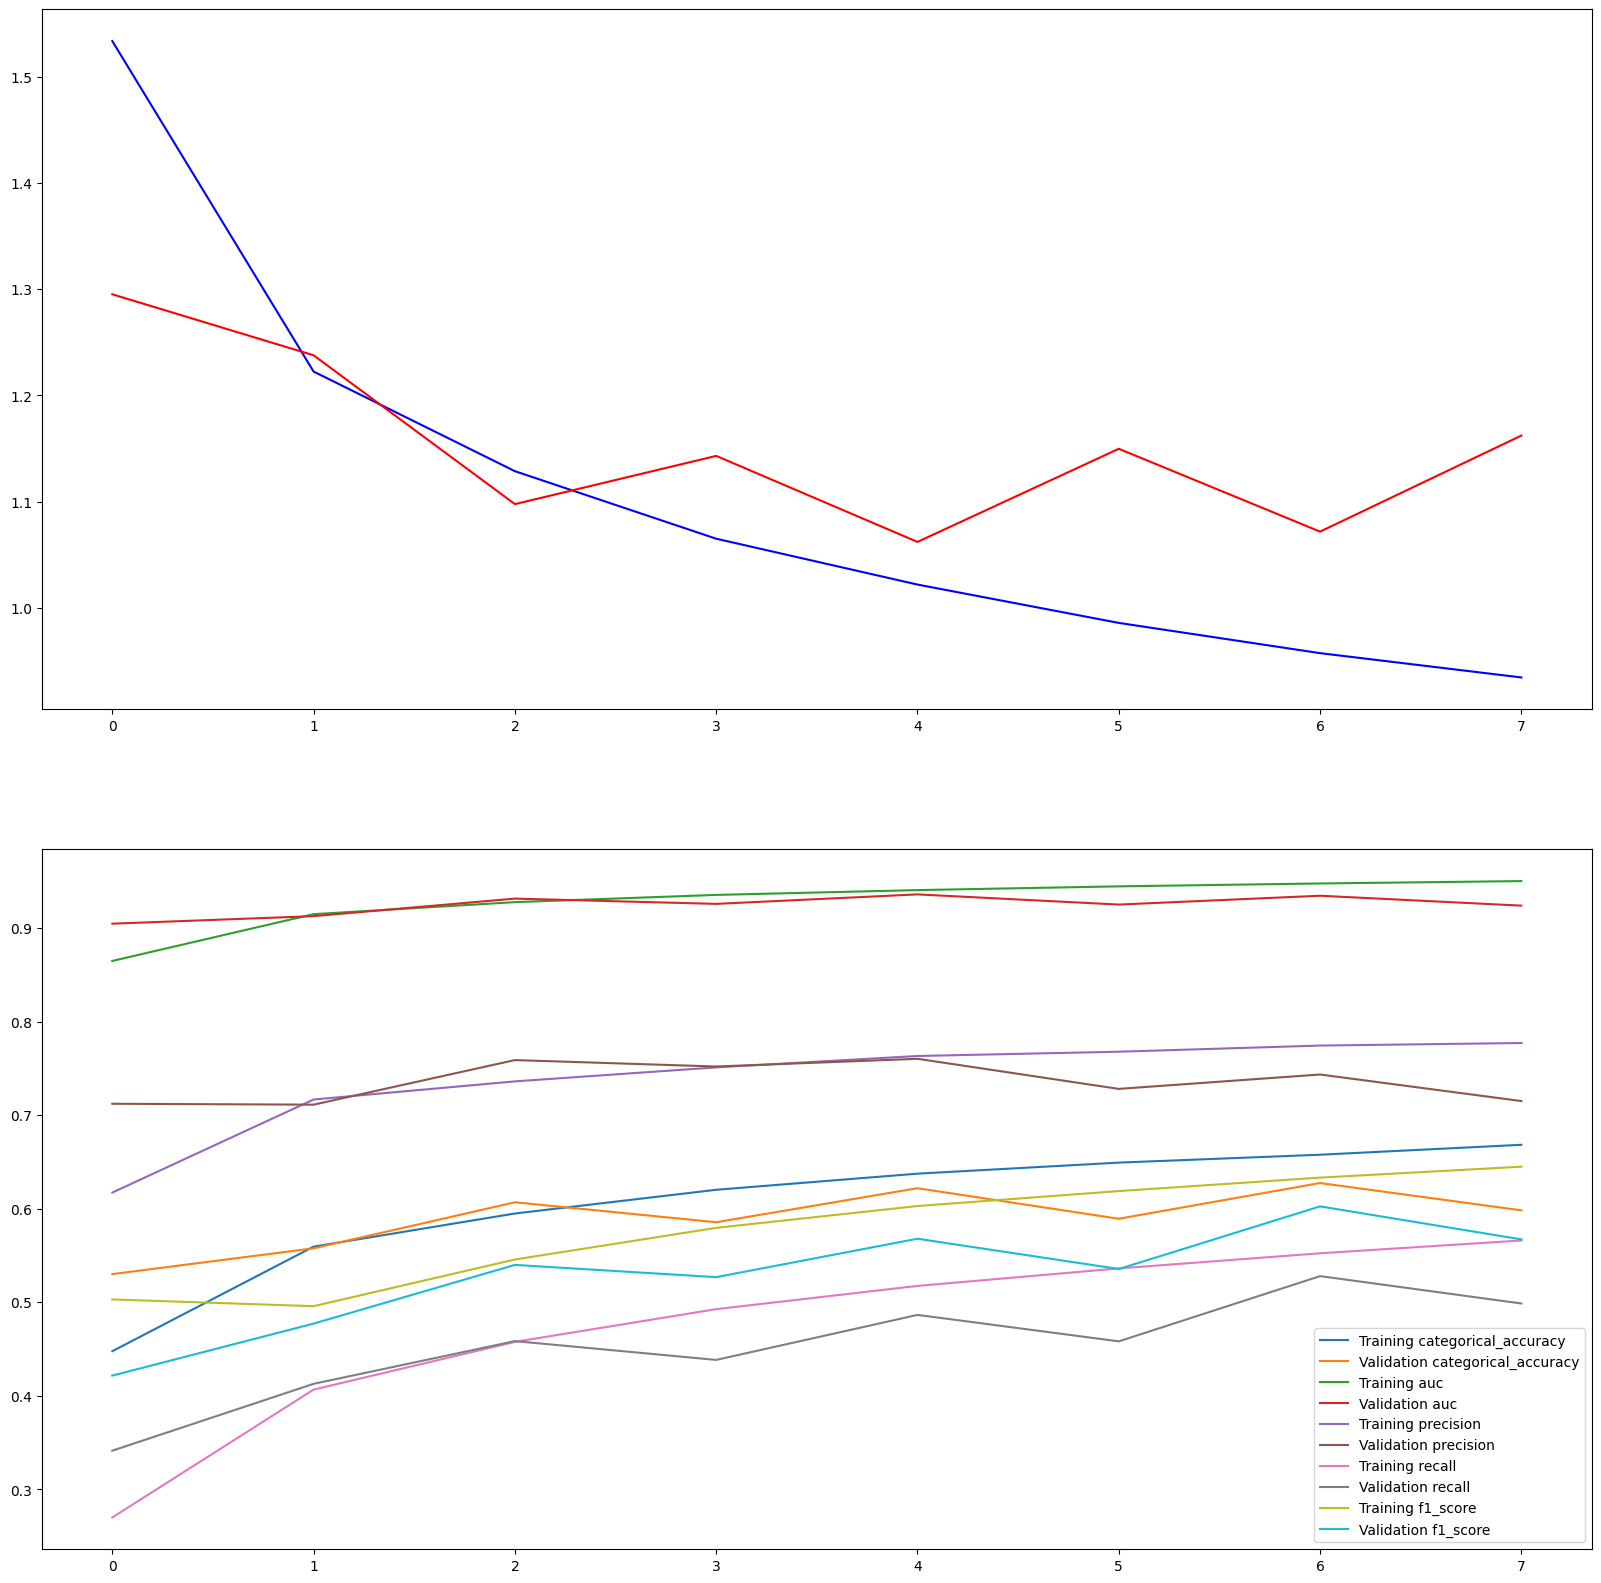

In [113]:
show_training_validation_loss_and_metrics(model14,metrics2)

In [114]:
model14.evaluate(test_it)

5625/5625 [==============================] - 61s 11ms/step - loss: 1.1724 - categorical_accuracy: 0.5963 - auc: 0.9227 - precision: 0.7139 - recall: 0.4950 - f1_score: 0.5640


[1.1723527908325195,
 0.596322238445282,
 0.922659158706665,
 0.7139491438865662,
 0.49498888850212097,
 0.5639867186546326]

5625/5625 [==============================] - 15s 3ms/step


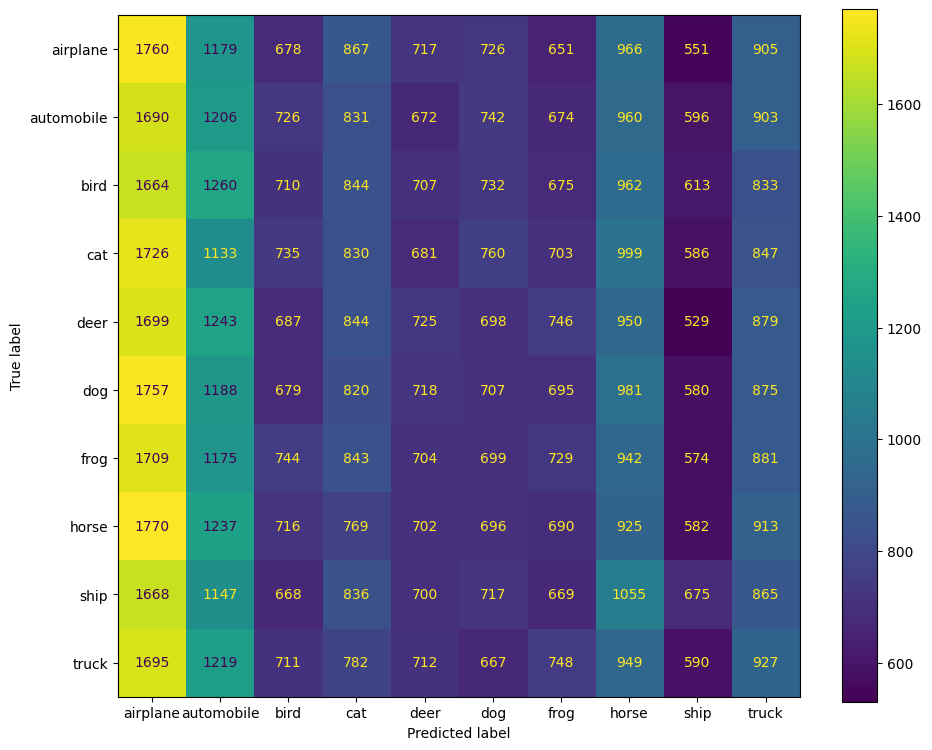

In [115]:
show_confusion_matrix(model14,test_ds,num_classes,class_names)

5625/5625 [==============================] - 16s 3ms/step


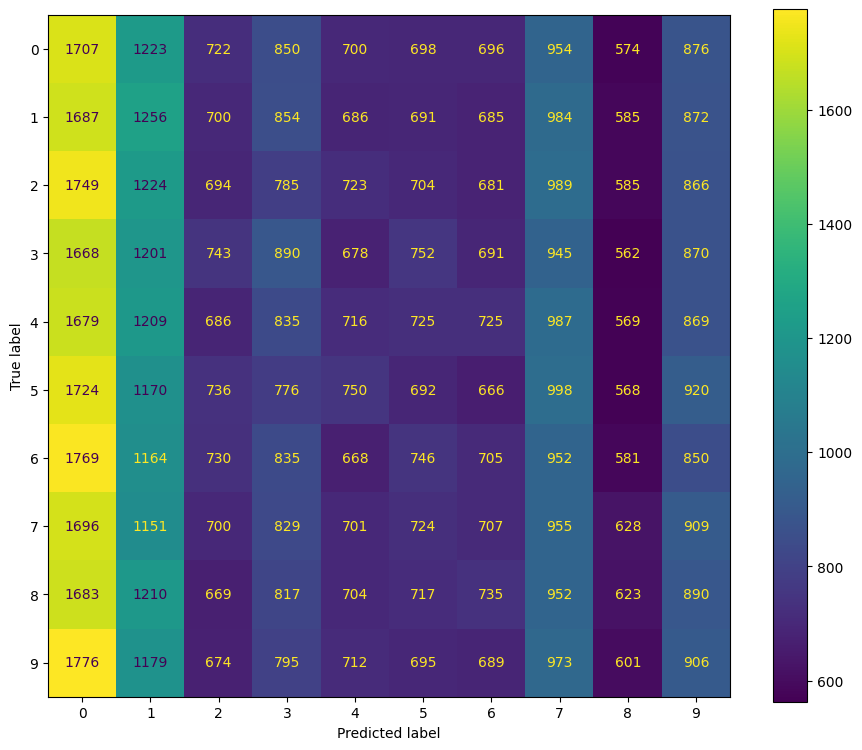

In [116]:
show_confusion_matrix_without_names(model14,test_ds,num_classes)

# Architektura drugiego modelu

In [117]:
model24 = create_model2(num_classes)

In [118]:
model24.compile( 
    loss=loss_func,
    metrics=metrics
)

In [119]:
model24.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_36 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_12 (Avera  (None, 16, 16, 75)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_53 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_37 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [120]:
history = model24.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 125s 22ms/step - loss: 1.6669 - categorical_accuracy: 0.3963 - auc: 0.8356 - precision: 0.6222 - recall: 0.1783 - f1_score: 0.4297 - val_loss: 1.3866 - val_categorical_accuracy: 0.4961 - val_auc: 0.8897 - val_precision: 0.7015 - val_recall: 0.2796 - val_f1_score: 0.3587
Epoch 2/20
5625/5625 [==============================] - 128s 23ms/step - loss: 1.3610 - categorical_accuracy: 0.5068 - auc: 0.8936 - precision: 0.6947 - recall: 0.3146 - f1_score: 0.4018 - val_loss: 1.2714 - val_categorical_accuracy: 0.5427 - val_auc: 0.9076 - val_precision: 0.7294 - val_recall: 0.3550 - val_f1_score: 0.4465
Epoch 3/20
5625/5625 [==============================] - 123s 22ms/step - loss: 1.2671 - categorical_accuracy: 0.5441 - auc: 0.9082 - precision: 0.7151 - recall: 0.3700 - f1_score: 0.4595 - val_loss: 1.2401 - val_categorical_accuracy: 0.5547 - val_auc: 0.9122 - val_precision: 0.7127 - val_recall: 0.3951 - val_f1_score: 0.4887
Epoch 4/20
5625/562

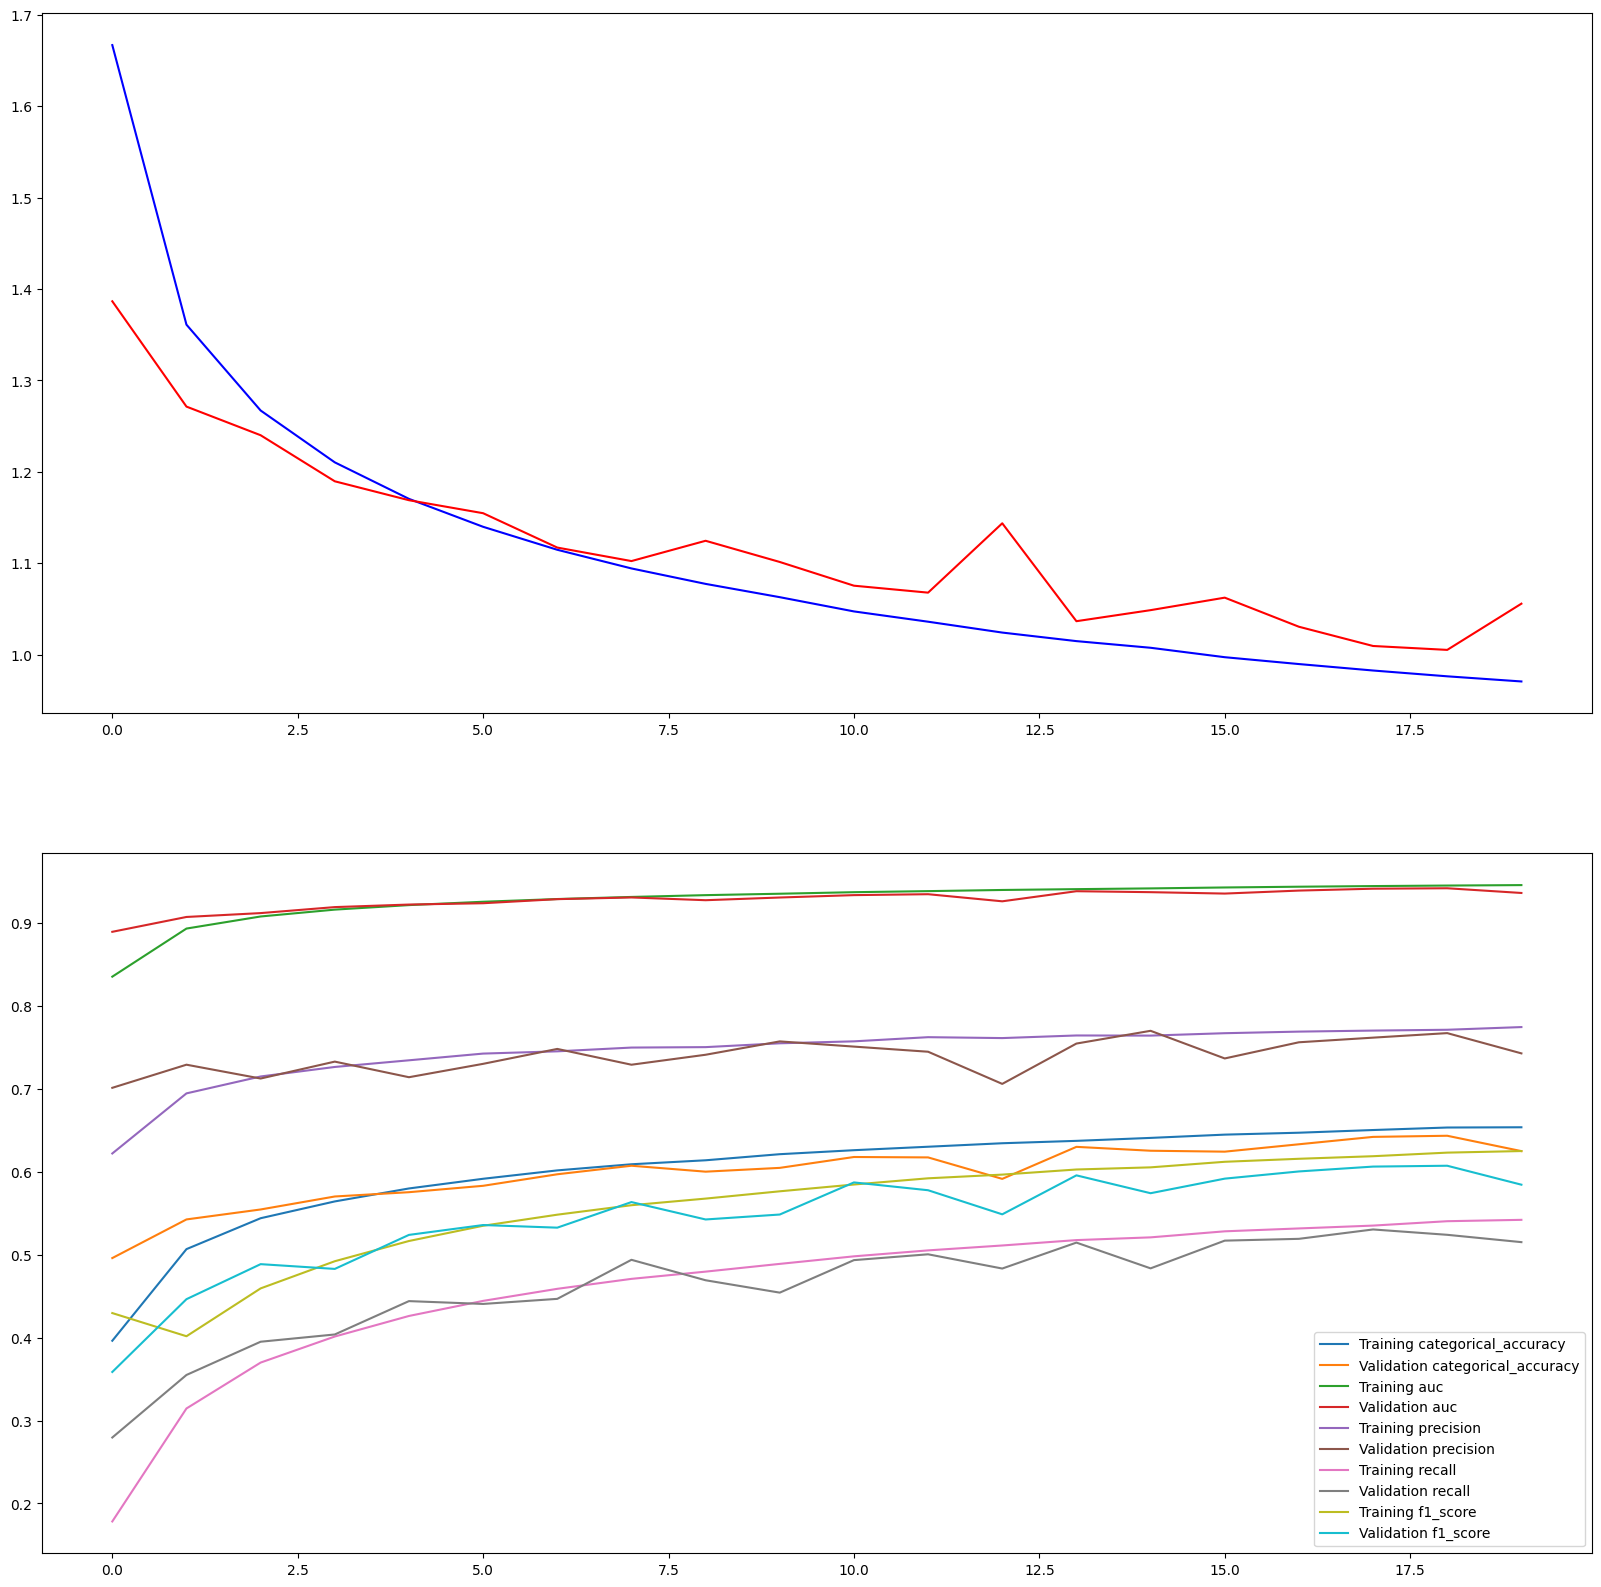

In [121]:
show_training_validation_loss_and_metrics(model24,metrics2)

In [122]:
model24.evaluate(test_it)

5625/5625 [==============================] - 66s 12ms/step - loss: 1.0609 - categorical_accuracy: 0.6243 - auc: 0.9360 - precision: 0.7424 - recall: 0.5137 - f1_score: 0.5825


[1.0609018802642822,
 0.6242555379867554,
 0.9359771013259888,
 0.7423959970474243,
 0.5136555433273315,
 0.5825352072715759]

5625/5625 [==============================] - 16s 3ms/step


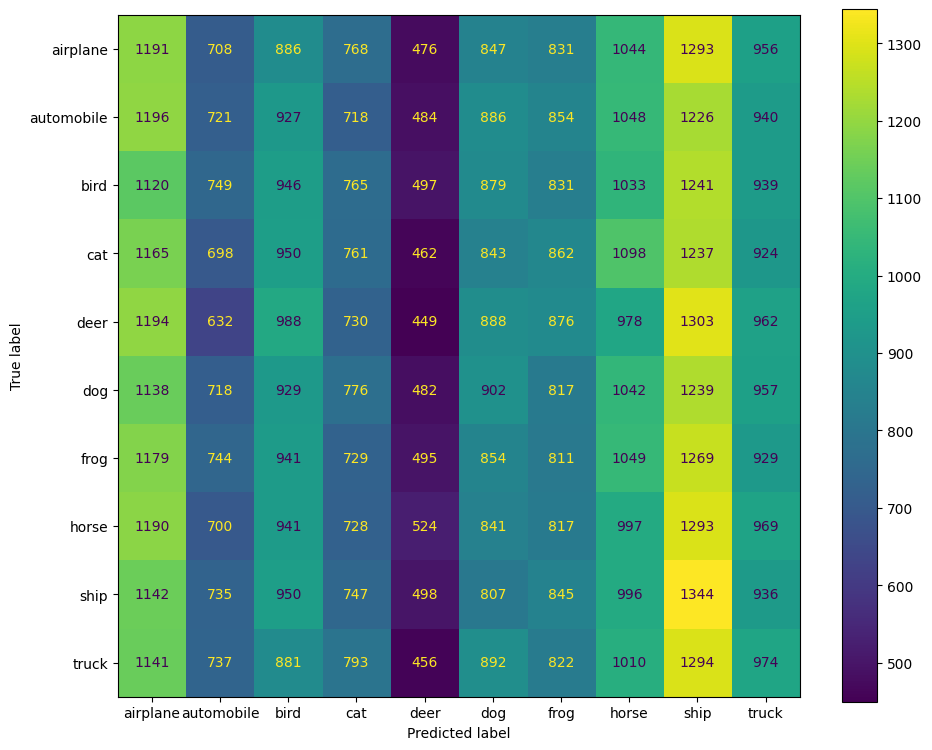

In [123]:
show_confusion_matrix(model24,test_ds,num_classes,class_names)

5625/5625 [==============================] - 18s 3ms/step


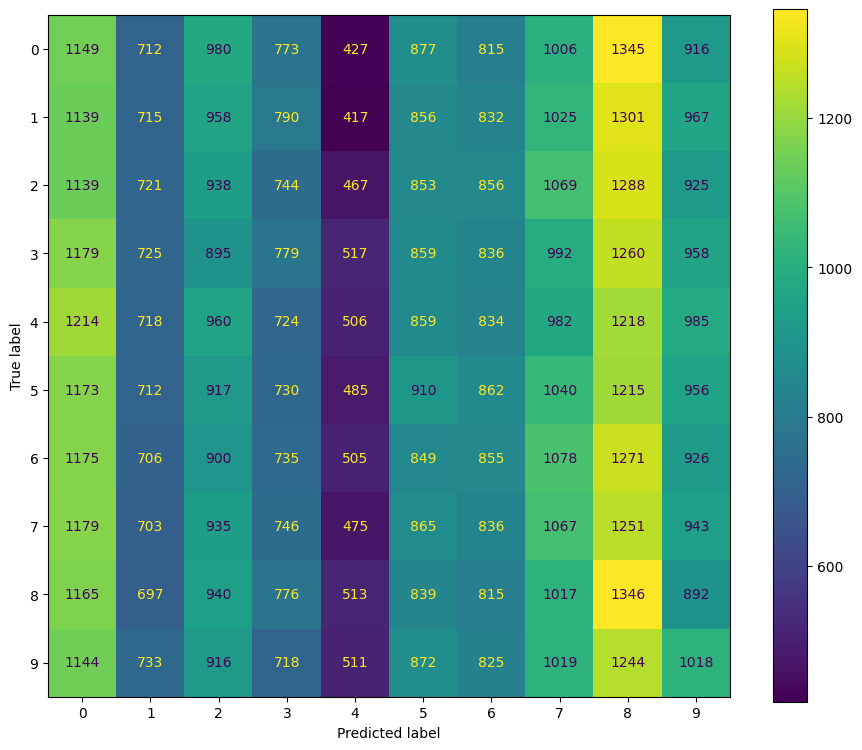

In [124]:
show_confusion_matrix_without_names(model24,test_ds,num_classes)

# Architektura trzeciego modelu

In [125]:
model34 = create_model3(num_classes)

model34.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

In [126]:
history = model34.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs, 
    callbacks = [callback]
)

Epoch 1/20
5625/5625 [==============================] - 130s 23ms/step - loss: 1.6325 - categorical_accuracy: 0.3836 - auc: 0.8411 - precision: 0.6383 - recall: 0.1533 - f1_score: 0.4308 - val_loss: 1.3933 - val_categorical_accuracy: 0.4809 - val_auc: 0.8886 - val_precision: 0.6823 - val_recall: 0.2820 - val_f1_score: 0.3458
Epoch 2/20
5625/5625 [==============================] - 129s 23ms/step - loss: 1.3547 - categorical_accuracy: 0.4993 - auc: 0.8949 - precision: 0.6925 - recall: 0.3056 - f1_score: 0.3839 - val_loss: 1.2493 - val_categorical_accuracy: 0.5404 - val_auc: 0.9114 - val_precision: 0.7162 - val_recall: 0.3612 - val_f1_score: 0.4288
Epoch 3/20
5625/5625 [==============================] - 131s 23ms/step - loss: 1.2555 - categorical_accuracy: 0.5396 - auc: 0.9102 - precision: 0.7119 - recall: 0.3656 - f1_score: 0.4475 - val_loss: 1.1935 - val_categorical_accuracy: 0.5658 - val_auc: 0.9191 - val_precision: 0.7380 - val_recall: 0.3900 - val_f1_score: 0.4723
Epoch 4/20
5625/562

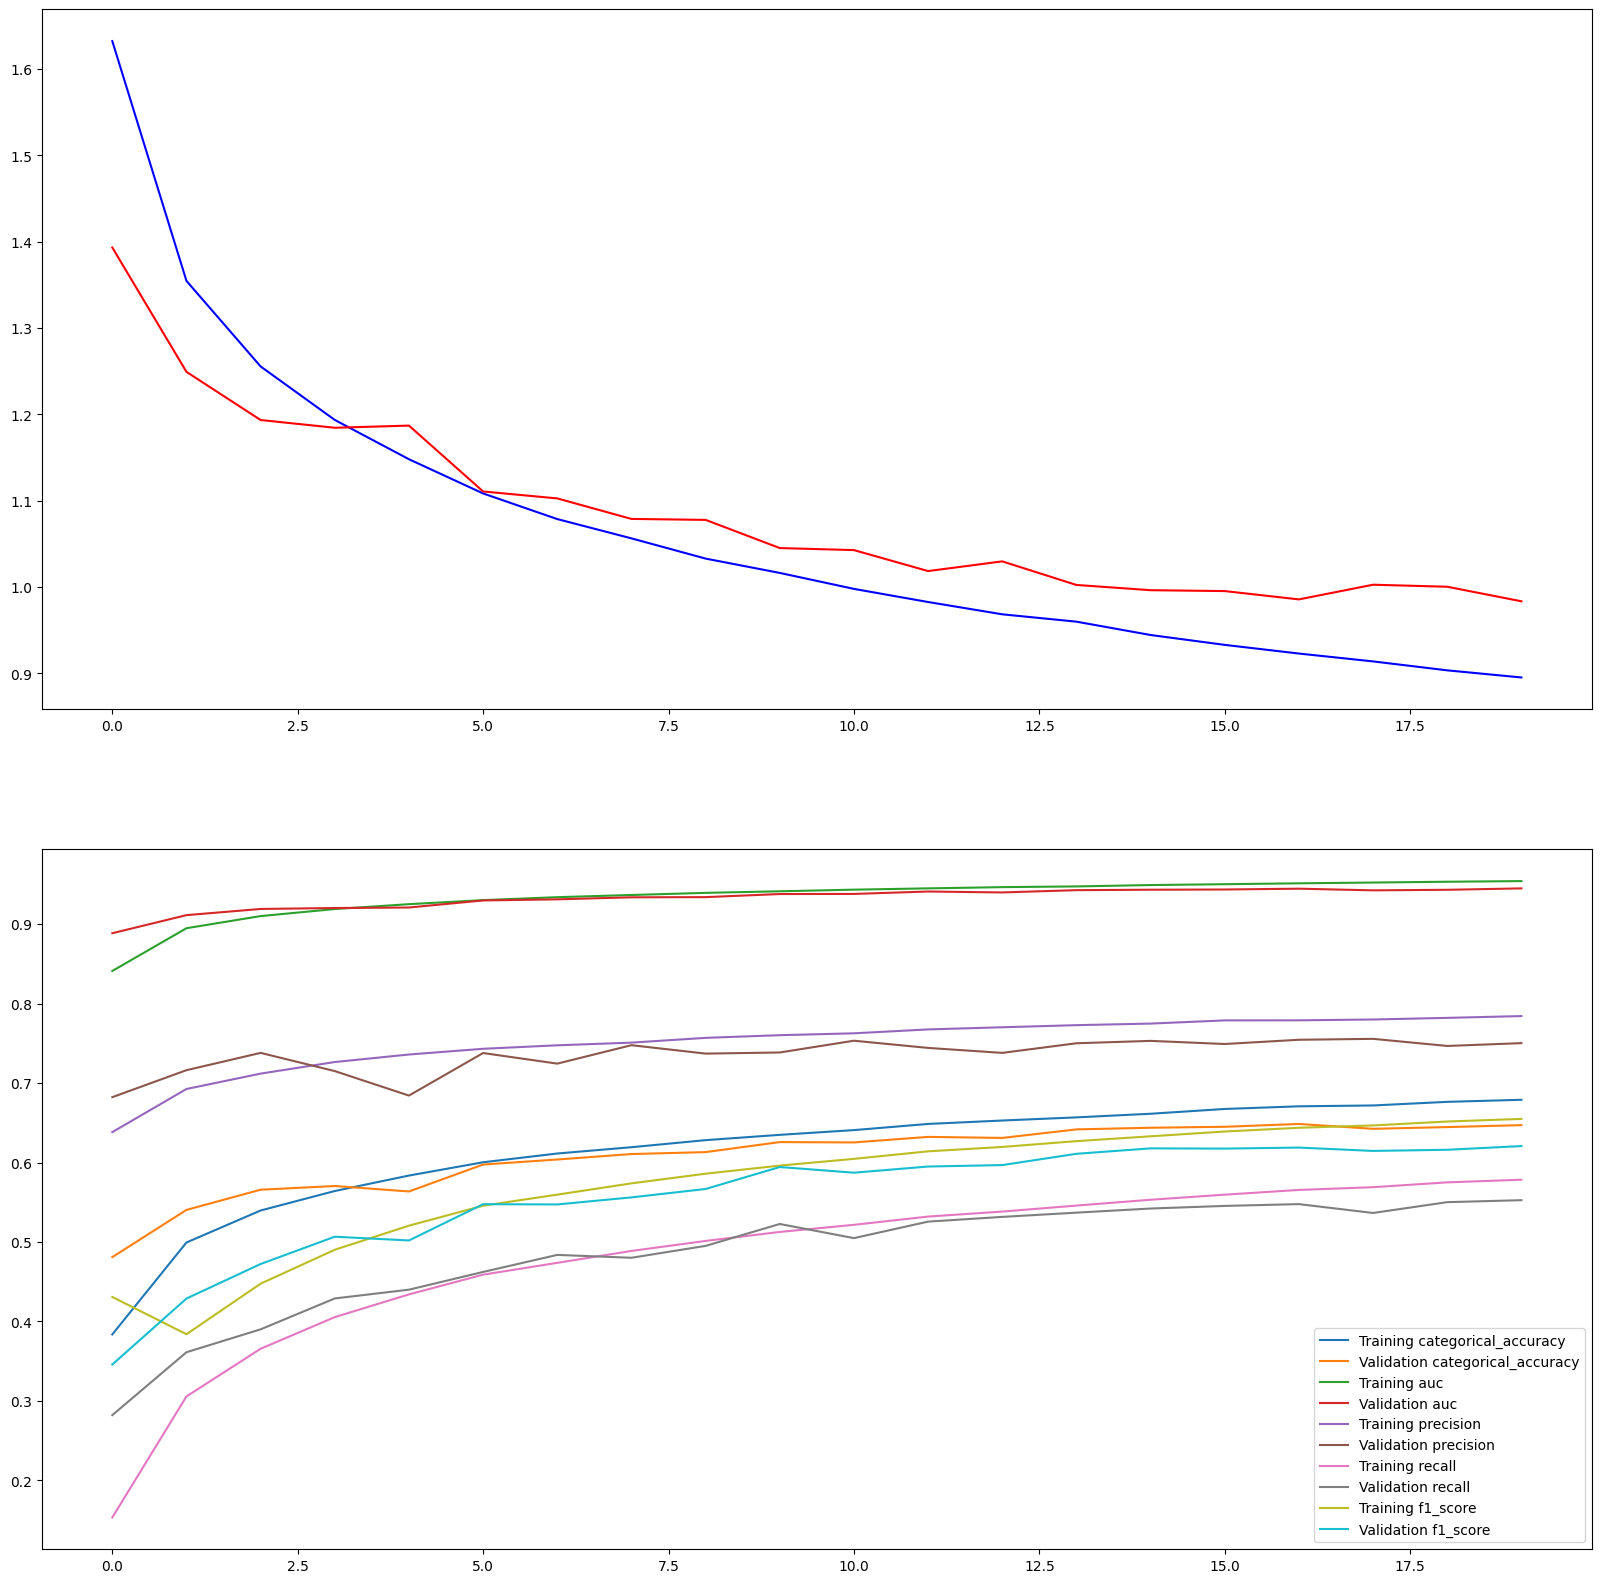

In [127]:
show_training_validation_loss_and_metrics(model34,metrics2)

In [128]:
model34.evaluate(test_it)

5625/5625 [==============================] - 64s 11ms/step - loss: 0.9951 - categorical_accuracy: 0.6465 - auc: 0.9437 - precision: 0.7479 - recall: 0.5501 - f1_score: 0.6191


[0.995134174823761,
 0.6465444564819336,
 0.9436982274055481,
 0.7478963732719421,
 0.5500777959823608,
 0.6191413402557373]

5625/5625 [==============================] - 18s 3ms/step


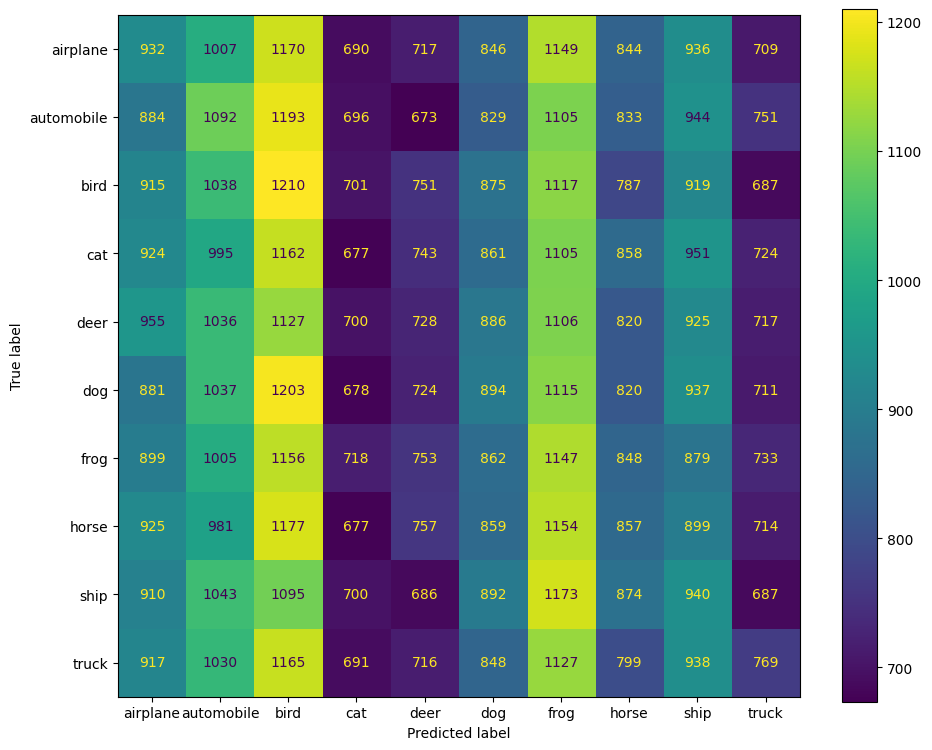

In [129]:
show_confusion_matrix(model34,test_ds,num_classes,class_names)

5625/5625 [==============================] - 17s 3ms/step


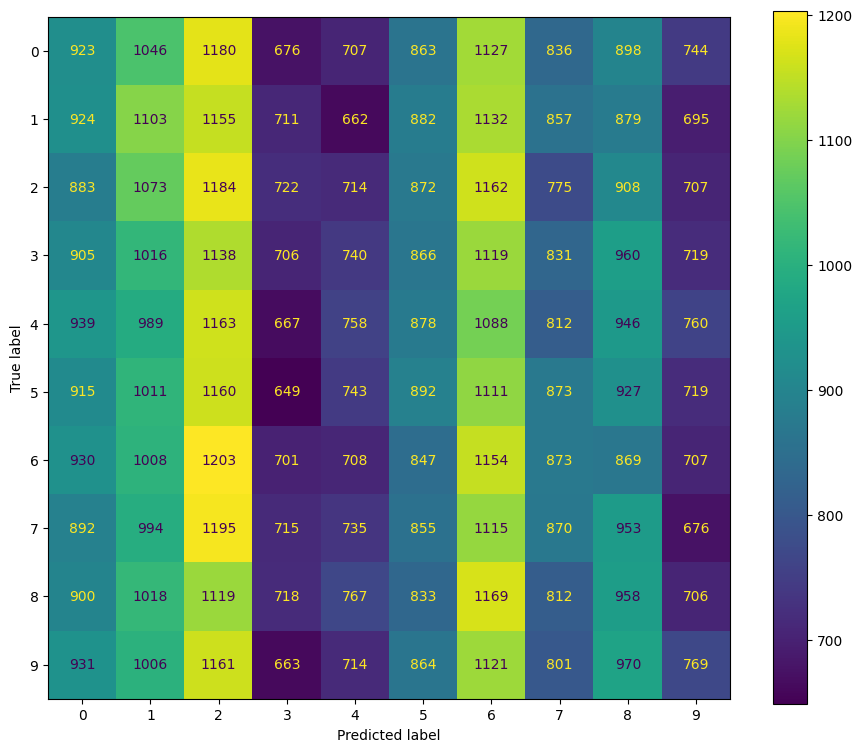

In [130]:
show_confusion_matrix_without_names(model34,test_ds,num_classes)